### Galaxy-Flux correlation in bins of K

In [2]:
import numpy as np
from astropy.table import Table
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import treecorr
import matplotlib.pyplot as plt


def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    from get_masks import get_milkyway_mask

    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458  # km/s
    chunksize = 200_000

    # Read header
    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
        filename,
        delim_whitespace=True,
        names=header,
        usecols=cols_to_use,
        skiprows=1,
        chunksize=chunksize
    ):
        
        # Exclude entries with no redshift
        chunk = chunk[chunk["dist_flag"] != 0]

        # Compute cz
        chunk["cz"] = c * chunk["z_cmb"]

        # Apply the main physical filters
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]

        # Compute absolute K magnitude
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25

        # Apply isfinite mask *inside the loop*
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"])
        chunk = chunk.loc[mask]

        # Append filtered data
        filtered_chunks.append(chunk)

    # Concatenate everything
    df = pd.concat(filtered_chunks, ignore_index=True)
    # Compute absolute K magnitude
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]
    df = df[df['Dec']<45.]

    print(f"Remaining galaxies after all cuts: {len(df)}")

    return df

def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    from get_masks import get_milkyway_mask

    # Generate random RA and Dec within specified declination limits
    rand_ra = np.random.uniform(0, 360, N_total*3)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total*3
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    # Apply Milky Way mask
    mask = get_milkyway_mask(rand_ra, rand_dec)
    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]
    if len(rand_ra) < N_total:
        raise ValueError(f"Not enough random points generated: {len(rand_ra)} < {N_total}")

    return rand_ra, rand_dec

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "num_bootstrap": 200,
    "cross_patch_weight": 'geom'
}

"""
READ DATA
"""
# === Load galaxy catalogue ===
cols = [
    "GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"
]
gxs = read_GLADE(cols)

# === Load flux catalog ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg', npatch=20)


/tmp/ipykernel_16838/1251932582.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978


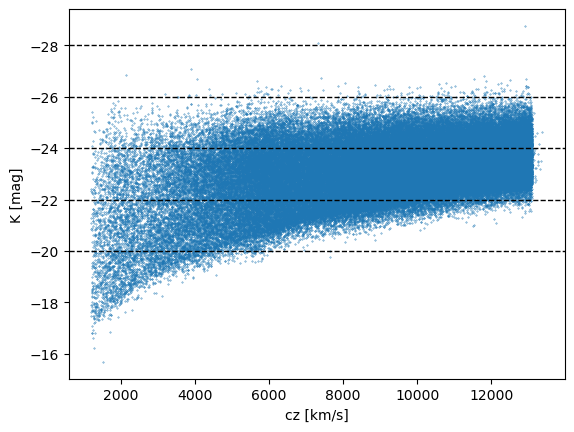

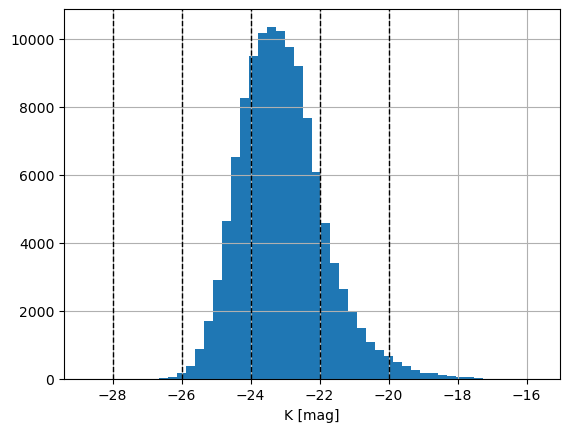

In [3]:
plt.scatter(gxs['cz'], gxs['M_K'], s=.1)
plt.xlabel('cz [km/s]')
plt.ylabel('K [mag]')
for K in [-20, -22, -24, -26, -28]:
    plt.axhline(K, color='k', ls='--', lw=1)
plt.axhline
plt.gca().invert_yaxis()
#plt.grid()
plt.show()

plt.hist(gxs['M_K'], bins=50, color='C0')
for K in [-20, -22, -24, -26, -28]:
    plt.axvline(K, color='k', ls='--', lw=1)
plt.xlabel('K [mag]')
plt.grid()
plt.show()

Processing slice: -22 -20
N. of galaxies in slice: 17224
Processing slice: -24 -22
N. of galaxies in slice: 70458
Processing slice: -26 -24
N. of galaxies in slice: 27014
Processing slice: -28 -26
N. of galaxies in slice: 151


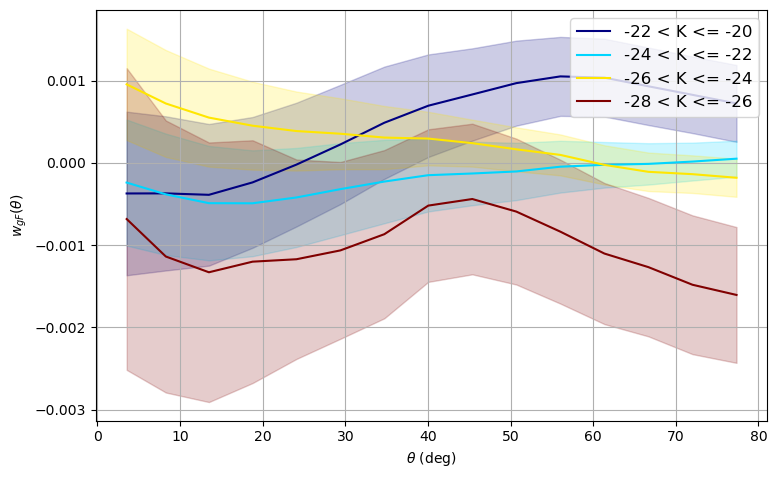

In [4]:

"""
CALCULATE CORRELATIONS FOR CZ SLICES
"""
k_slices = [(-20,-22), (-22,-24), (-24,-26), (-26,-28)]
colors = plt.cm.jet(np.linspace(0, 1, len(k_slices)))  # Color gradient

fig, ax = plt.subplots(figsize=(8, 5))

for i, (k_max, k_min) in enumerate(k_slices):

    print('Processing slice:', k_min, k_max)

    # Filter galaxies for the current cz slice
    gxs_slice = gxs[(gxs['M_K'] > k_min) & (gxs['M_K'] <= k_max)]

    print('N. of galaxies in slice:', len(gxs_slice))

    # Generate random catalog for the current slice
    rand_ra, rand_dec = generate_RanCat(len(gxs_slice)*10, dec_min=-90, dec_max=45)

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
                                  ra_units='deg', dec_units='deg', npatch=20)
    rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, 
                                ra_units='deg', dec_units='deg', patch_centers=gcat_slice.patch_centers)

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    xi, varxi = nk.calculateXi(rk=rk)

    xi = xi / flux_val.mean()  # Normalize by mean flux value
    # Plot with color gradient
    # plt.errorbar(nk.meanr, xi/flux_val.mean(), yerr=varxi**.5, fmt='o-', color=colors[i],
    #              label=f'{cz_min} < cz <= {cz_max}')
    plt.fill_between(nk.meanr, xi - varxi**0.5, xi + varxi**0.5, 
                     color=colors[i], alpha=0.2)  # Add error band
    plt.plot(nk.meanr, xi, color=colors[i], label=f'{k_min} < K <= {k_max}')

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 16,     # x/y labels
    'axes.titlesize': 18,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})

# Add colorbar using a dummy ScalarMappable
# norm = plt.Normalize(vmin=cz_slices[0][0], vmax=cz_slices[-1][1])
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm.set_array([])  # dummy array
# cbar = fig.colorbar(sm, ax=ax)
# cbar.set_label('cz range')

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('gal_flux_correlation.png', dpi=300)  # Save the figure
plt.show()

### Low K gxs have more correlation with flux, but there is a bias with cz 

/tmp/ipykernel_16838/1251932582.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978
-20
-23
-26


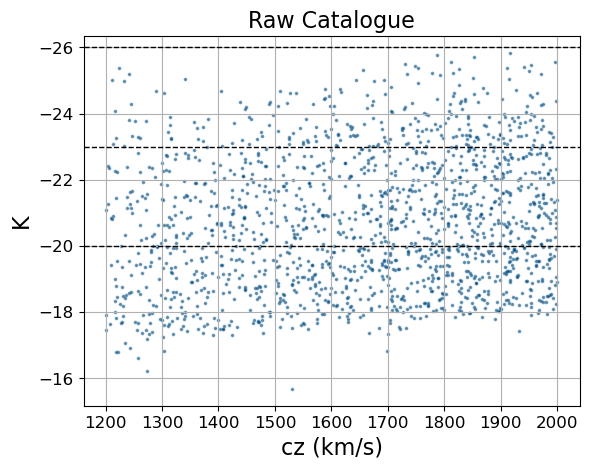

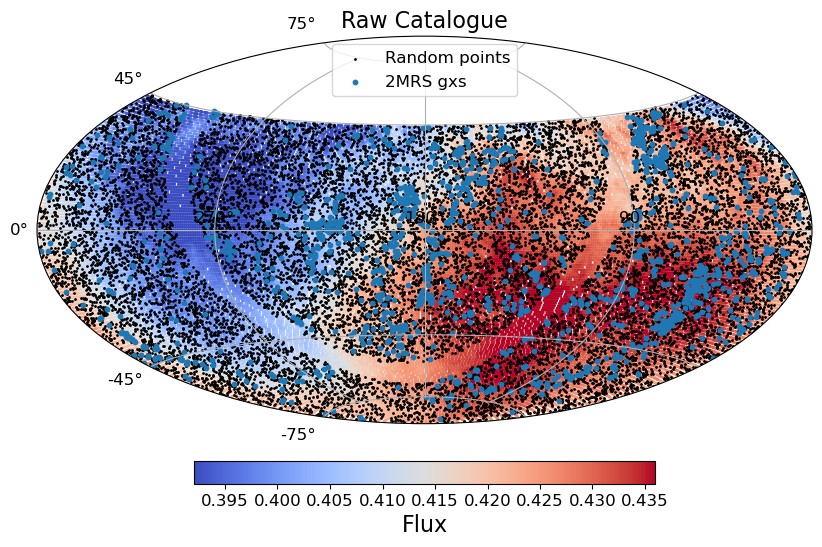

Processing slice: -21 -20
Processing slice: -26 -23


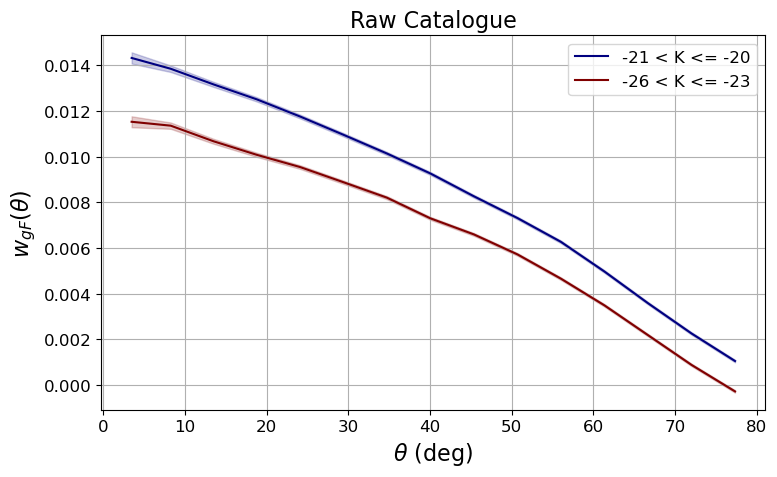

In [5]:
"""
CALCULATE CORRELATIONS FOR K SLICES WITH CZ CUT
"""
# === Load Galaxies ===
gxs = read_GLADE(cols)
k_slices = [(-20, -21), (-23,-26)]
colors_kslices = plt.cm.jet(np.linspace(0, 1, len(k_slices)))  # Color gradient

gxs_K = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 2000)]  # Apply cz cut to galaxy catalog

# === Load Flux map ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg')#, npatch=10)

# Generate random catalog for the current slice
rand_ra, rand_dec = generate_RanCat(len(gxs_K)*10, dec_min=-90, dec_max=45)

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    #"var_method": 'bootstrap',
    #"num_bootstrap": 500,
    "cross_patch_weight": 'geom'
}

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 16,     # x/y labels
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})
#################
#################
# Plot K vs CZ
#################
#################
plt.scatter(gxs_K['cz'], gxs_K['M_K'], s=3, color='C0', alpha=0.5, label='K vs cz', facecolor='k')
for K in [item[0] for item in k_slices] + [k_slices[-1][1]]:
    print(K)
    plt.axhline(K, color='k', ls='--', lw=1)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('cz (km/s)')
plt.ylabel('K')
plt.title('Raw Catalogue')
plt.show()

#################
#################
# Plot SkyMap
#################
#################
from matplotlib import colors

# === Plot ===
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

# Set ticks
xticks_deg = [270, 180, 90]
xticks_rad = -np.radians(xticks_deg) + np.pi
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f"{d}°" for d in xticks_deg])

yticks_deg = [-75, -45, 0, 45, 75]
yticks_rad = np.radians(yticks_deg)
ax.set_yticks(yticks_rad)
ax.set_yticklabels([f"{d}°" for d in yticks_deg])

# === Flux Scatter plot (with horizontal colorbar below) ===
norm_flux = colors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
sc = ax.scatter(np.deg2rad(-flux_ra+180.), np.deg2rad(flux_dec), c=flux_val, s=5, cmap='coolwarm', norm=norm_flux, edgecolor='none')

# Horizontal colorbar for Flux
cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
cbar_flux.set_label("Flux")

ax.scatter(np.deg2rad(-rand_ra+180.), np.deg2rad(rand_dec), s=1, color='k', label='Random points')
ax.scatter(np.deg2rad(-gxs_K['RA']+180.), np.deg2rad(gxs_K['Dec']), s=10, color='C0', label='2MRS gxs')
plt.legend()
plt.title('Raw Catalogue')
plt.show()

######################
######################
# Plot Correlations
######################
######################
fig, ax = plt.subplots(figsize=(8, 5))
for i, (k_max, k_min) in enumerate(k_slices):

    print('Processing slice:', k_min, k_max)

    # Filter galaxies for the current cz slice
    gxs_slice = gxs_K[(gxs_K['M_K'] > k_min) & (gxs_K['M_K'] <= k_max)]

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
                                  ra_units='deg', dec_units='deg')#, npatch=10)
    rand_cat = treecorr.Catalog(ra=rand_ra[:len(gxs_slice)*10], dec=rand_dec[:len(gxs_slice)*10], 
                                ra_units='deg', dec_units='deg')#, patch_centers=gcat_slice.patch_centers)

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    xi, varxi = nk.calculateXi(rk=rk)
    xi /= flux_val.mean()  # Normalize by mean flux value
    varxi = varxi / (flux_val.mean()**2)

    plt.fill_between(nk.meanr, xi - (varxi**0.5), xi + (varxi**0.5), 
                     color=colors_kslices[i], alpha=0.2)  # Add error band
    plt.plot(nk.meanr, xi, color=colors_kslices[i], label=f'{k_min} < K <= {k_max}')

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.title('Raw Catalogue')
plt.tight_layout()
#plt.savefig('gal_flux_correlation.png', dpi=300)  # Save the figure
plt.show()

#### Just want to check controlled catalogue

-21
-23
-26


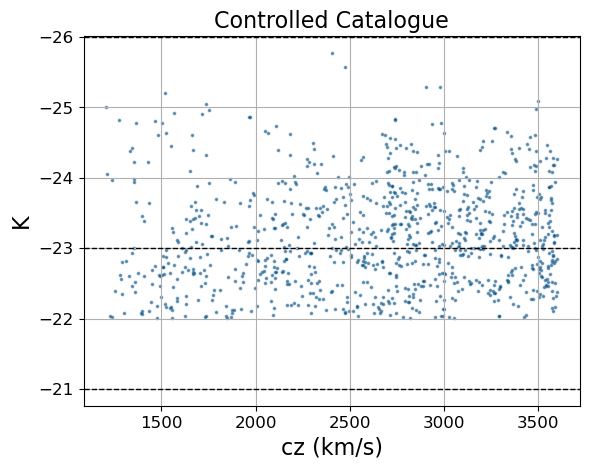

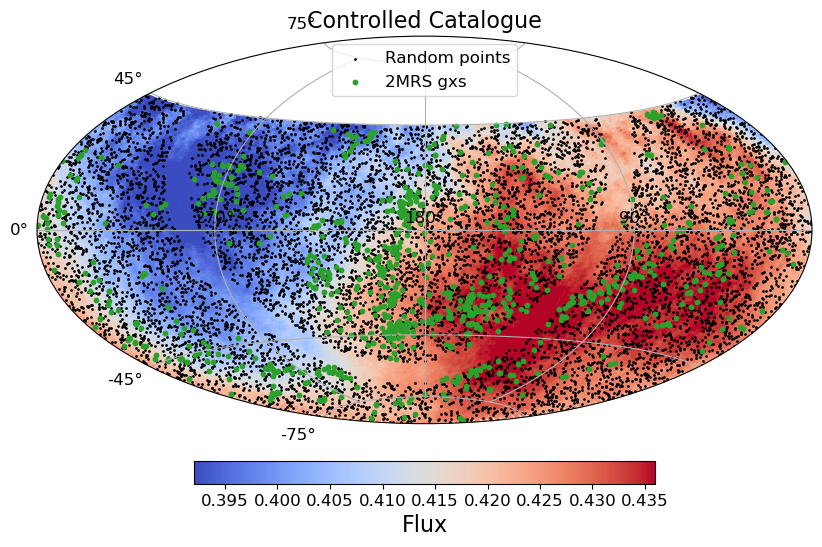

Processing slice: -23 -21
[0.00883464 0.00888601 0.00865312 0.00831897 0.007961   0.00765315
 0.0072956  0.00696301 0.00645762 0.00576033 0.00481936 0.00389057
 0.00298281 0.00205276 0.00129517] [8.85766742e-06 8.27738122e-06 7.57707801e-06 7.07812555e-06
 6.41930763e-06 5.89787910e-06 5.71629987e-06 5.67257734e-06
 5.65468805e-06 5.64033797e-06 5.70050880e-06 5.90035727e-06
 6.12035059e-06 6.18471180e-06 6.18899849e-06]
Processing slice: -26 -23
[ 1.10586656e-02  1.09882738e-02  1.06938750e-02  1.02747569e-02
  9.84116227e-03  9.23290063e-03  8.61838144e-03  7.98208659e-03
  7.21645681e-03  6.17782130e-03  5.12021020e-03  3.78569367e-03
  2.39242668e-03  1.08283938e-03 -8.20495036e-06] [1.17880909e-05 1.08487921e-05 1.00213118e-05 9.36741414e-06
 8.74930360e-06 8.25066850e-06 8.01804069e-06 7.89453420e-06
 7.72496348e-06 7.56490823e-06 7.32783530e-06 7.12809128e-06
 6.94130450e-06 6.57338188e-06 6.31276645e-06]


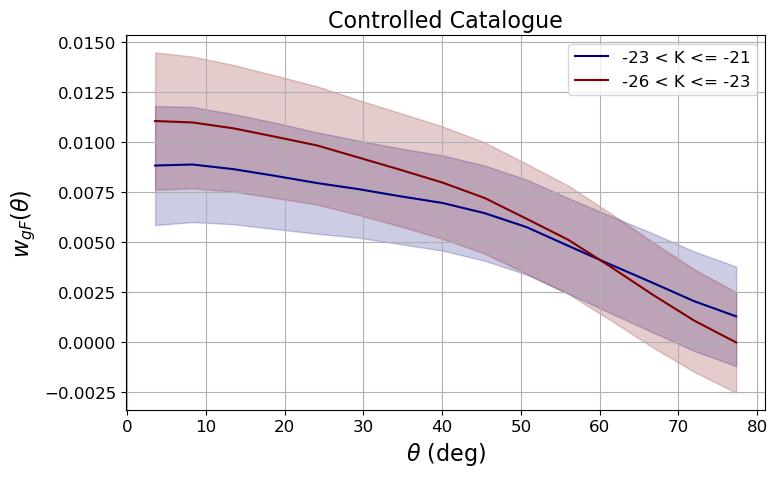

In [6]:
"""
CALCULATE CORRELATIONS FOR K SLICES WITH CZ CUT
"""
# === Load Galaxies ===
from astropy.io import ascii
gxs_file = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISEniBPT_control_SF_passive_cz_Kabs_ang5_cz1000.txt'
gxs = ascii.read(gxs_file)
gxs['M_Ks'] = gxs['K_abs']

k_slices = [(-21,-23), (-23,-26)]
colors_kslices = plt.cm.jet(np.linspace(0, 1, len(k_slices)))  # Color gradient

gxs_K = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 3600)]  # Apply cz cut to galaxy catalog

# === Load Flux map ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg', npatch=30)

# Generate random catalog
rand_ra, rand_dec = generate_RanCat(len(gxs_K)*10, dec_min=-90, dec_max=45)

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "num_bootstrap": 500,
    "cross_patch_weight": 'geom'
}

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 16,     # x/y labels
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})
#################
#################
# Plot K vs CZ
#################
#################
plt.scatter(gxs_K['cz'], gxs_K['M_Ks'], s=3, color='C0', alpha=0.5, label='K vs cz', facecolor='k')
for K in [item[0] for item in k_slices] + [k_slices[-1][1]]:
    print(K)
    plt.axhline(K, color='k', ls='--', lw=1)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('cz (km/s)')
plt.ylabel('K')
plt.title('Controlled Catalogue')
plt.show()

#################
#################
# Plot SkyMap
#################
#################
from matplotlib import colors

# === Plot ===
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

# Set ticks
xticks_deg = [270, 180, 90]
xticks_rad = -np.radians(xticks_deg) + np.pi
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f"{d}°" for d in xticks_deg])

yticks_deg = [-75, -45, 0, 45, 75]
yticks_rad = np.radians(yticks_deg)
ax.set_yticks(yticks_rad)
ax.set_yticklabels([f"{d}°" for d in yticks_deg])

# === Flux Scatter plot (with horizontal colorbar below) ===
norm_flux = colors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
sc = ax.scatter(np.deg2rad(-flux_ra+180.), np.deg2rad(flux_dec), c=flux_val, s=5, cmap='coolwarm', norm=norm_flux)

# Horizontal colorbar for Flux
cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
cbar_flux.set_label("Flux")

ax.scatter(np.deg2rad(-rand_ra+180.), np.deg2rad(rand_dec), s=1, color='k', label='Random points')
ax.scatter(np.deg2rad(-gxs_K['_RAJ2000']+180.), np.deg2rad(gxs_K['_DEJ2000']), s=10, color='C2', label='2MRS gxs')
plt.legend()
plt.title('Controlled Catalogue')
plt.show()

######################
######################
# Plot Correlations
######################
######################
fig, ax = plt.subplots(figsize=(8, 5))
for i, (k_max, k_min) in enumerate(k_slices):

    print('Processing slice:', k_min, k_max)

    # Filter galaxies for the current cz slice
    gxs_slice = gxs_K[(gxs_K['M_Ks'] > k_min) & (gxs_K['M_Ks'] <= k_max)]

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(ra=gxs_slice['_RAJ2000'], dec=gxs_slice['_DEJ2000'],
                                  ra_units='deg', dec_units='deg', npatch=30)
    rand_cat = treecorr.Catalog(ra=rand_ra[:len(gxs_slice)*10], dec=rand_dec[:len(gxs_slice)*10], 
                                ra_units='deg', dec_units='deg', patch_centers=gcat_slice.patch_centers)

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    #xi, varxi = nk.calculateXi(rk=rk)
    #xi = xi / flux_val.mean()  # Normalize by mean flux value

    # Pruebita
    xi = (nk.xi - flux_val.mean())  / flux_val.mean()  
    varxi = nk.varxi
    print(xi, varxi)
    #plt.errorbar(nk.meanr, xi, yerr=(varxi**.5), fmt='o-', color=colors_kslices[i])
    plt.fill_between(nk.meanr, xi - varxi**0.5, xi + varxi**0.5, 
                     color=colors_kslices[i], alpha=0.2)  # Add error band
    plt.plot(nk.meanr, xi, color=colors_kslices[i], label=f'{k_min} < K <= {k_max}')

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.title('Controlled Catalogue')
plt.tight_layout()
#plt.savefig('gal_flux_correlation.png', dpi=300)  # Save the figure
plt.show()

### Plot con el raw catalog
### Bootstrap artesanales (sólo bootstrapear galaxias)

/tmp/ipykernel_16838/1251932582.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978
-20
-21.5
-23
-27


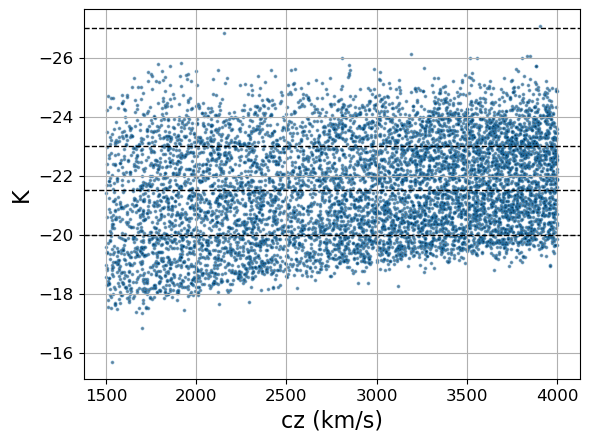

Processing slice: -21.5 -20
N. of galaxies in slice: 2172


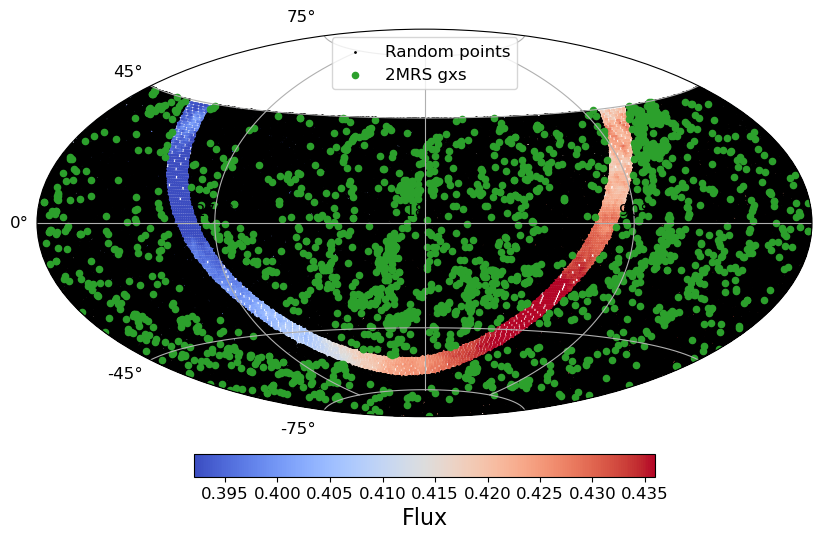

Processing slice: -22 -21.5
N. of galaxies in slice: 636


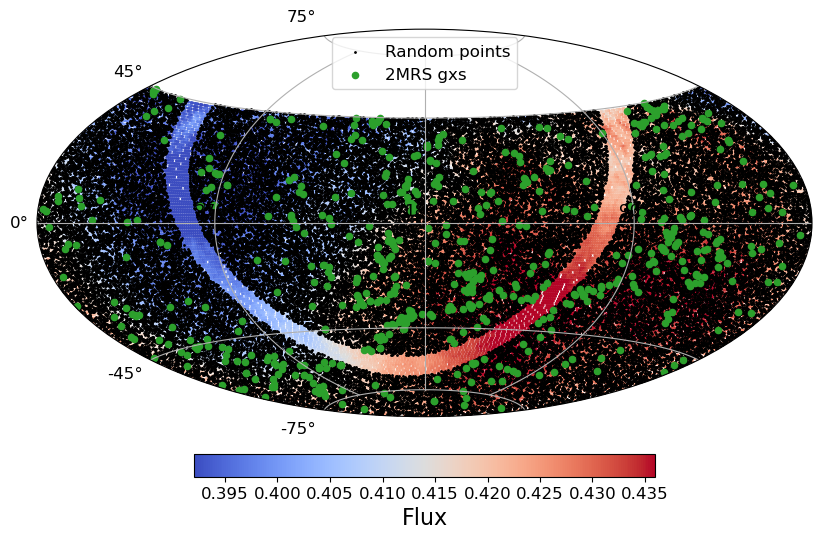

Processing slice: -27 -23
N. of galaxies in slice: 1805


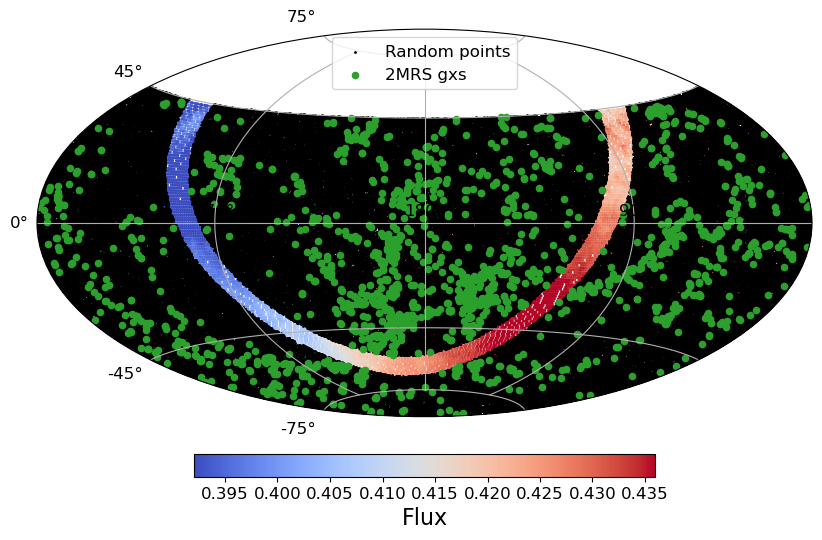

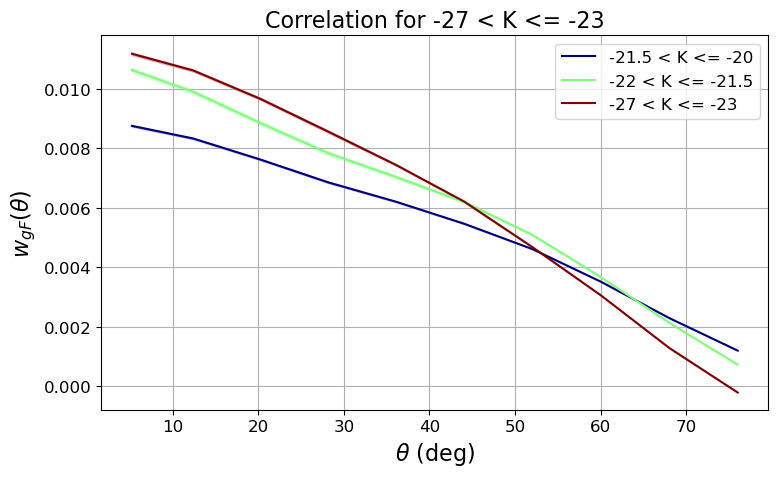

In [7]:
"""
CALCULATE CORRELATIONS FOR K SLICES WITH CZ CUT
"""
# === Load Galaxies ===
gxs = read_GLADE(cols)
k_slices = [(-20, -21.5), (-21.5, -22), (-23,-27)]
colors_kslices = plt.cm.jet(np.linspace(0, 1, len(k_slices)))  # Color gradient
nrand = 100

gxs_K = gxs[(gxs['cz'] >= 1500) & (gxs['cz'] <= 4000)]  # Apply cz cut to galaxy catalog

# === Load Flux map ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg')#, npatch=10)

# Generate random catalog for the current slice
rand_ra, rand_dec = generate_RanCat(len(gxs_K)*nrand, dec_min=-90, dec_max=45)

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 10,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    #"var_method": 'bootstrap',
    #"num_bootstrap": 500,
    "cross_patch_weight": 'geom'
}

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 16,     # x/y labels
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})
#################
#################
# Plot K vs CZ
#################
#################
plt.scatter(gxs_K['cz'], gxs_K['M_K'], s=3, color='C0', alpha=0.5, label='K vs cz', facecolor='k')
for K in [item[0] for item in k_slices] + [k_slices[-1][1]]:
    print(K)
    plt.axhline(K, color='k', ls='--', lw=1)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('cz (km/s)')
plt.ylabel('K')
#plt.title('Raw Catalogue')
plt.show()
plt.close()

from matplotlib import colors
def sky_plot(rand_ra, rand_dec, flux_ra, flux_dec, flux_val, gxs_K):

    # === Plot ===
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111, projection='hammer')
    ax.grid(True)

    # Set ticks
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f"{d}°" for d in xticks_deg])

    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)
    ax.set_yticks(yticks_rad)
    ax.set_yticklabels([f"{d}°" for d in yticks_deg])

    # === Flux Scatter plot (with horizontal colorbar below) ===
    norm_flux = colors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
    sc = ax.scatter(np.deg2rad(-flux_ra+180.), np.deg2rad(flux_dec), c=flux_val, s=5, cmap='coolwarm', norm=norm_flux, edgecolor='none')

    # Horizontal colorbar for Flux
    cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
    cbar_flux.set_label("Flux")

    ax.scatter(np.deg2rad(-rand_ra+180.), np.deg2rad(rand_dec), s=1, color='k', label='Random points')
    ax.scatter(np.deg2rad(-gxs_K['RA']+180.), np.deg2rad(gxs_K['Dec']), \
               s=20, color='C2', label='2MRS gxs')
    plt.legend()
    #plt.title('Raw Catalogue')
    plt.show()
    plt.close()

# --- bootstrap variance function (uses same estimator and same rk) ---
def get_bootstrap_variance(gxs_slice, rand_cat, fcat, config, num_bootstrap=500, use_patches=False):
    nbins = config['nbins']
    xi_bs = np.zeros((num_bootstrap, nbins))

    if use_patches:
        # Example using healpix patch bootstrap (recommended if you care about spatial systematics)
        import healpy as hp
        nside = 16   # tune this (8,16,32) depending on patch size you want
        npix = hp.nside2npix(nside)
        # get pixel indices for galaxies
        theta = np.deg2rad(90. - gxs_slice['Dec'])
        phi = np.deg2rad(gxs_slice['RA'])
        gpix = hp.ang2pix(nside, theta, phi)
        patch_indices = [np.where(gpix == p)[0] for p in range(npix)]

        for i in range(num_bootstrap):
            sel_patches = np.random.randint(0, npix, size=npix)
            idxs = np.concatenate([patch_indices[p] for p in sel_patches if patch_indices[p].size>0])
            if idxs.size == 0:
                continue
            gbs = gxs_slice[idxs]

            gcat_bs = treecorr.Catalog(ra=gbs['RA'], dec=gbs['Dec'],
                                    ra_units='deg', dec_units='deg')
            nk_bs = treecorr.NKCorrelation(config)
            rk_bs = treecorr.NKCorrelation(config)
            nk_bs.process(gcat_bs, fcat)
            rk_bs.process(rand_cat, fcat)          # keep the same randoms (they describe geometry)
            xi_bs[i], _ = nk_bs.calculateXi(rk=rk_bs)
    else:
        # Simple iid bootstrap (fast, ok if spatial systematics are negligible)
        for i in range(num_bootstrap):
            sel = np.random.choice(len(gxs_slice), size=len(gxs_slice), replace=True)
            gbs = gxs_slice.iloc[sel]
            gcat_bs = treecorr.Catalog(ra=gbs['RA'], dec=gbs['Dec'],
                                    ra_units='deg', dec_units='deg')
            nk_bs = treecorr.NKCorrelation(config)
            rk_bs = treecorr.NKCorrelation(config)
            nk_bs.process(gcat_bs, fcat)
            rk_bs.process(rand_cat, fcat)
            xi_bs[i], _ = nk_bs.calculateXi(rk=rk_bs)

    return np.var(xi_bs, axis=0, ddof=1)

######################
######################
# Plot Correlations (separately for each K slice)
######################
######################

results = []  # store (meanr, xi, varxi, label) for each slice

for i, (k_max, k_min) in enumerate(k_slices):

    print('Processing slice:', k_min, k_max)

    # Filter galaxies for the current k slice
    gxs_slice = gxs_K[(gxs_K['M_K'] > k_min) & (gxs_K['M_K'] <= k_max)]
    print('N. of galaxies in slice:', len(gxs_slice))

    # Sky plot for this slice
    sky_plot(rand_ra[:len(gxs_slice)*nrand], rand_dec[:len(gxs_slice)*nrand],
             flux_ra, flux_dec, flux_val, gxs_slice)

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(
        ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
        ra_units='deg', dec_units='deg'
    )
    rand_cat = treecorr.Catalog(
        ra=rand_ra[:len(gxs_slice)*nrand], dec=rand_dec[:len(gxs_slice)*nrand],
        ra_units='deg', dec_units='deg'
    )

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    xi, _ = nk.calculateXi(rk=rk)
    xi /= flux_val.mean()  # Normalize by mean flux

    # Bootstrap variance
    var_bs = get_bootstrap_variance(gxs_slice, rand_cat, fcat,
                                    config, num_bootstrap=20, use_patches=False)
    varxi = var_bs / (flux_val.mean()**2)

    # Store results for later plotting
    results.append((nk.meanr, xi, varxi, f'{k_min} < K <= {k_max}', colors_kslices[i]))

plt.figure(figsize=(8, 5))
# --- Plot each correlation separately ---
for meanr, xi, varxi, label, color in results:
    plt.fill_between(meanr, xi - (varxi**0.5), xi + (varxi**0.5),
                     color=color, alpha=0.2)
    plt.plot(meanr, xi, color=color, label=label)
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$w_{gF}(\theta)$')
plt.grid()
plt.legend(loc='upper right')
plt.title(f'Correlation for {label}')
plt.tight_layout()
plt.show()


/tmp/ipykernel_16228/1582945075.py:77: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Galaxies after masks: 116978

Processing slice: -20.5 -20
Galaxies in slice: 744
Patch statistics:
  Number of patches       : 600
  Empty patches          : 134, 22.3%
  Patches with <10 gxs   : 600 , 100.0%
  Mean gxs per patch     : 1.2
  Median gxs per patch   : 1.0
The following patch numbers have no objects: {515, 518, 519, 520, 522, 525, 532, 534, 29, 31, 554, 556, 45, 559, 50, 53, 566, 61, 62, 575, 577, 578, 69, 581, 587, 596, 91, 95, 109, 110, 123, 143, 146, 154, 166, 170, 175, 187, 209, 219, 225, 226, 227, 228, 231, 232, 233, 234, 236, 237, 239, 240, 241, 242, 243, 258, 260, 262, 267, 285, 300, 301, 304, 306, 307, 311, 314, 316, 317, 318, 319, 320, 322, 323, 325, 328, 334, 336, 337, 338, 341, 342, 346, 347, 349, 350, 352, 361, 363, 365, 368, 372, 373, 375, 381, 383, 384, 386, 387, 388, 391, 393, 400, 401, 403, 406, 411, 412, 414, 416, 418, 419, 424, 425, 430, 432, 434, 435, 440, 441, 442, 446, 448, 460, 465, 468, 473, 475, 485, 486, 489, 497, 499, 503}
This may be a problem d

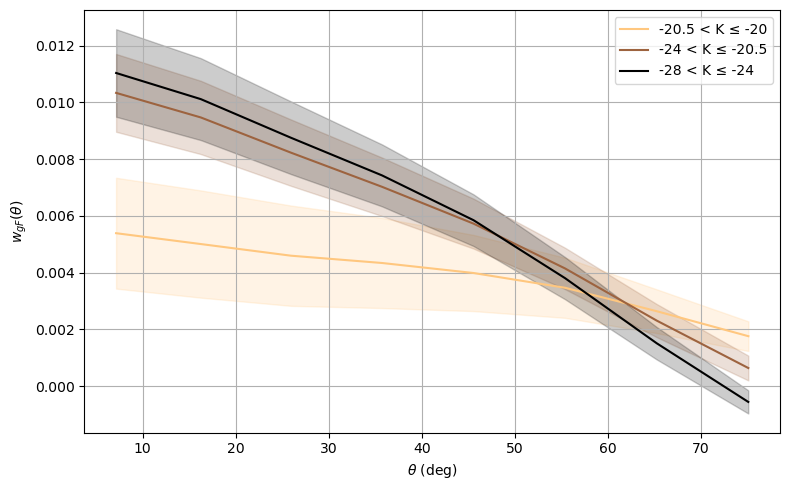

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import treecorr
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter


# ============================================================
#  PATCH ESTIMATOR
# ============================================================

def suggest_npatch_from_area(
        area_deg2,
        theta_max_deg,
        N_gal,
        factor=1.,
        min_per_patch=0,
        verbose=True
    ):
    """
    Suggest TreeCorr npatch using:
      - geometric scale: patch radius > theta_max
      - survey area constraint
      - minimum galaxies/patch constraint
    """

    R_patch = factor * (theta_max_deg/2)
    A_patch = np.pi * R_patch**2

    npatch_ideal = max(1, int(round(area_deg2 / A_patch)))
    if min_per_patch!=0: 
        npatch_max_from_gal = max(1, N_gal // min_per_patch)

        # Final choice
        npatch = max(2, min(npatch_ideal, npatch_max_from_gal))
    
    else:
        npatch = max(2, npatch_ideal)
        npatch_max_from_gal = None

    if verbose:
        print("----- TreeCorr npatch suggestion -----")
        #print(f"Survey area            : {area_deg2:.1f} deg²")
        #print(f"Theta max              : {theta_max_deg}°")
        #print(f"Patch radius           : {R_patch:.1f}°")
        #print(f"Patch area             : {A_patch:.1f} deg²")
        print(f"Ideal npatch (area)    : {npatch_ideal}")
        print(f"Max npatch (gal count) : {npatch_max_from_gal}")
        print(f"Final suggested npatch : {npatch}")
        #print(f"Galaxies per patch     : {N_gal/npatch:.1f}")
        print("--------------------------------------")

    return npatch


# ============================================================
#  CATALOG LOADING
# ============================================================

def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    """
    Load and filter GLADE catalog in chunks for memory efficiency.
    """
    from get_masks import get_milkyway_mask

    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458
    chunksize = 200_000

    # Load header
    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    chunks = []

    for chunk in pd.read_csv(
            filename,
            delim_whitespace=True,
            names=header,
            usecols=cols_to_use,
            skiprows=1,
            chunksize=chunksize
        ):

        chunk = chunk[chunk["dist_flag"] != 0]   # Remove missing redshifts
        chunk["cz"] = c * chunk["z_cmb"]

        # Physical cuts
        good = (chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)
        chunk = chunk.loc[good]

        # Compute M_K
        chunk["M_K"] = chunk["K"] - 5*np.log10(chunk["d_L"]) - 25
        chunk = chunk[np.isfinite(chunk["M_K"])]

        chunks.append(chunk)

    df = pd.concat(chunks, ignore_index=True)

    df["M_K"] = df["K"] - 5.*np.log10(df["d_L"]) - 25.
    df = df[df["Dec"] < 45.]  # survey cut
    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]

    print(f"Galaxies after masks: {len(df)}")
    return df


# ============================================================
#  RANDOM CATALOG GENERATOR
# ============================================================

def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    """
    Generate random RA/Dec respecting declination limits and MW mask.
    """
    from get_masks import get_milkyway_mask

    # Draw more points than needed
    RA = np.random.uniform(0, 360, N_total*3)
    sindec = np.random.uniform(
        np.sin(np.radians(dec_min)),
        np.sin(np.radians(dec_max)),
        N_total*3
    )
    DEC = np.degrees(np.arcsin(sindec))

    mask = get_milkyway_mask(RA, DEC)
    RA, DEC = RA[mask][:N_total], DEC[mask][:N_total]

    if len(RA) < N_total:
        raise ValueError("Not enough random points after masking.")

    return RA, DEC


# ============================================================
#  PLOTTING UTILITIES
# ============================================================

def sky_plot(rand_ra, rand_dec, flux_ra, flux_dec, flux_val, gxs_slice):
    """
    Hammer projection plot of randoms, flux, and galaxy positions.
    """
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111, projection='hammer')
    ax.grid(True)

    # X ticks
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f"{d}°" for d in xticks_deg])

    # Y ticks
    yticks_deg = [-75, -45, 0, 45, 75]
    ax.set_yticks(np.radians(yticks_deg))
    ax.set_yticklabels([f"{d}°" for d in yticks_deg])

    # Flux map
    norm = colors.Normalize(
        vmin=np.percentile(flux_val, 5),
        vmax=np.percentile(flux_val, 95)
    )
    sc = ax.scatter(
        np.deg2rad(-flux_ra+180.),
        np.deg2rad(flux_dec),
        c=flux_val, s=5,
        cmap='coolwarm', norm=norm,
        edgecolor='none'
    )
    plt.colorbar(sc, ax=ax, orientation='horizontal',
                 pad=0.08, fraction=0.05).set_label("Flux")

    # Randoms and galaxies
    ax.scatter(np.deg2rad(-rand_ra+180.), np.deg2rad(rand_dec),
               s=1, color='k', label='Random')
    ax.scatter(np.deg2rad(-gxs_slice['RA']+180.),
               np.deg2rad(gxs_slice['Dec']),
               s=20, color='C2', label='Galaxies')

    plt.legend()
    plt.show()
    plt.close()


# ============================================================
#  CORRELATION PIPELINE
# ============================================================

def compute_correlation_slice(gxs_slice, rand_ra, rand_dec, fcat, config, npatch):
    """
    Compute NK correlation for single galaxy slice.
    """
    Ng = len(gxs_slice)
    nrand = len(rand_ra)

    gcat = treecorr.Catalog(
        ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
        ra_units='deg', dec_units='deg',
        npatch=npatch
    )
    rcat = treecorr.Catalog(
        ra=rand_ra[:nrand], dec=rand_dec[:nrand],
        ra_units='deg', dec_units='deg',
        patch_centers=gcat.patch_centers
    )

    # See patch occupation statistics
    n_patches = len(gcat.patch_centers)
    cpp = np.bincount(gcat.patch, minlength=n_patches) # counts per patch
    cpp_zeros = np.sum(cpp == 0)
    cpp_lt10 = np.sum(cpp < 10)
    cpp_mean, cpp_median = np.mean(cpp), np.median(cpp)
    print('Patch statistics:')
    print(f'  Number of patches       : {n_patches}')
    print(f'  Empty patches          : {cpp_zeros}, {cpp_zeros/n_patches*100:.1f}%')
    print(f'  Patches with <10 gxs   : {cpp_lt10}', f', {cpp_lt10/n_patches*100:.1f}%')
    print(f'  Mean gxs per patch     : {cpp_mean:.1f}')
    print(f'  Median gxs per patch   : {cpp_median:.1f}')


    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat, fcat)
    rk.process(rcat, fcat)

    # manual w = (D-R)/R
    xi = nk.xi / rk.xi - 1
    varxi = nk.varxi / (rk.xi**2)

    return nk.meanr, xi, varxi


# ============================================================
#  MAIN EXECUTION
# ============================================================

# ---- Load Data ----
gxs = read_GLADE(["GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"])
gxs_K = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 4000)]

k_slices = [(-20, -20.5), (-20.5, -24), (-24, -28)]
colors_kslices = plt.cm.copper_r(np.linspace(0, 1, len(k_slices)))

# ---- Load Flux ----
flux_cat = np.loadtxt("../data/Auger/flux_a8_lb.dat")
flux_dec, flux_ra, flux_val = flux_cat[:,0], flux_cat[:,1], flux_cat[:,2]

# TreeCorr flux catalog
fcat = treecorr.Catalog(
    ra=flux_ra, dec=flux_dec,
    k=flux_val, ra_units='deg', dec_units='deg'
)

# ---- Random catalog ----
nrand = 100
rand_ra, rand_dec = generate_RanCat(len(gxs_K)*nrand)

# TreeCorr settings
config = dict(
    min_sep=1,
    max_sep=80.,
    nbins=8,
    sep_units='degree',
    bin_type='Linear',
    brute=False,
    metric='Arc',
    var_method='jackknife',
    #num_bootstrap=5000,
    cross_patch_weight='match'
)

# ---- Loop over slices ----
results = []
npatch_params = {"area": 35212, "theta_max": 20, "factor": 1., "min_per_patch": 0}

for (k_max, k_min), color in zip(k_slices, colors_kslices):

    print("\nProcessing slice:", k_min, k_max)

    gxs_slice = gxs_K[
        (gxs_K['M_K'] > k_min) &
        (gxs_K['M_K'] <= k_max)
    ]
    Ng = len(gxs_slice)
    print("Galaxies in slice:", Ng)

    # npatch = suggest_npatch_from_area(
    #     npatch_params['area'],
    #     npatch_params['theta_max'],
    #     Ng,
    #     factor=npatch_params['factor'],
    #     min_per_patch=npatch_params['min_per_patch'],
    #     verbose=True
    # )

    npatch = 600
    meanr, xi, varxi = compute_correlation_slice(
        gxs_slice, rand_ra[:Ng*nrand], rand_dec[:Ng*nrand],
        fcat, config, npatch
    )
    results.append((meanr, xi, varxi, f"{k_min} < K ≤ {k_max}", color))


# ============================================================
#  PLOT CORRELATIONS
# ============================================================

plt.figure(figsize=(8, 5))

for meanr, xi, varxi, label, color in results:
    plt.fill_between(meanr, xi - np.sqrt(varxi), xi + np.sqrt(varxi),
                     color=color, alpha=0.2)
    plt.plot(meanr, xi, color=color, label=label)

plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$w_{gF}(\theta)$')
plt.grid()
plt.legend()
plt.tight_layout()
#plt.savefig('../plots/gal_flux_correlation_k.png', dpi=100)
plt.show()
plt.close()


### Bootstraps artesanales

/tmp/ipykernel_31351/484105961.py:60: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978
K slice percentiles (25%,75%): [-22.69500074 -20.99120836]


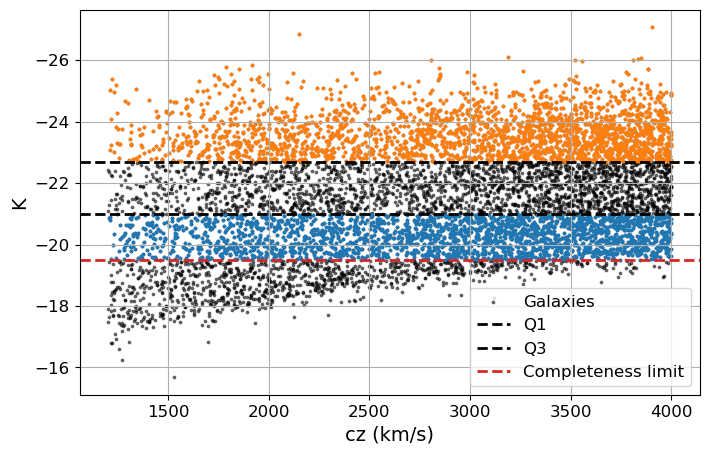


Processing slice: -20.991208357822707 -19.5
Galaxies in slice: 2293
The following patch numbers have no objects: {291, 261, 165, 201, 21}
This may be a problem depending on your use case.
The following patch numbers have no objects: {291, 261, 165, 201, 273, 21, 222}
This may be a problem depending on your use case.

Processing slice: -27.070903351817996 -22.69500074251535
Galaxies in slice: 2292
The following patch numbers have no objects: {102, 328, 41, 49, 252}
This may be a problem depending on your use case.
The following patch numbers have no objects: {102, 328, 41, 49, 252}
This may be a problem depending on your use case.
Skyplot saved to ../plots/plot3_skymap_galaxies_k.png


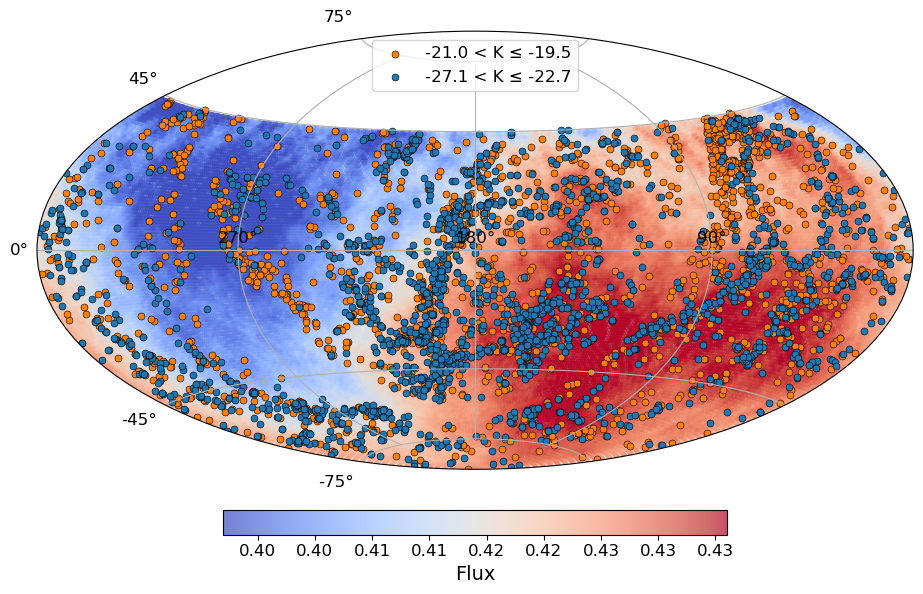

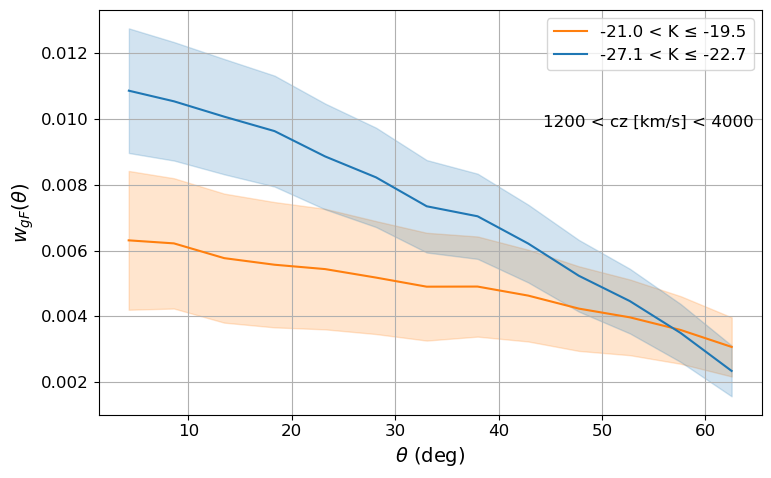

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import treecorr
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter


# ============================================================
#  PATCH ESTIMATOR (unchanged)
# ============================================================

def suggest_npatch_from_area(
        area_deg2,
        theta_max_deg,
        N_gal,
        factor=1.5,
        min_per_patch=50,
        verbose=True
    ):
    R_patch = factor * (theta_max_deg/2)
    A_patch = np.pi * R_patch**2

    npatch_ideal = max(1, int(round(area_deg2 / A_patch)))
    npatch_max_from_gal = max(1, N_gal // min_per_patch)

    npatch = max(2, min(npatch_ideal, npatch_max_from_gal))

    if verbose:
        print("----- TreeCorr npatch suggestion -----")
        print(f"Survey area            : {area_deg2:.1f} deg²")
        print(f"Theta max              : {theta_max_deg}°")
        print(f"Patch radius           : {R_patch:.1f}°")
        print(f"Patch area             : {A_patch:.1f} deg²")
        print(f"Ideal npatch (area)    : {npatch_ideal}")
        print(f"Max npatch (gal count) : {npatch_max_from_gal}")
        print(f"Final suggested npatch : {npatch}")
        print(f"Galaxies per patch     : {N_gal/npatch:.1f}")
        print("--------------------------------------")

    return npatch


# ============================================================
#  CATALOG LOADING (unchanged)
# ============================================================

def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    from get_masks import get_milkyway_mask

    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458
    chunksize = 200_000

    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    chunks = []

    for chunk in pd.read_csv(
            filename,
            delim_whitespace=True,
            names=header,
            usecols=cols_to_use,
            skiprows=1,
            chunksize=chunksize
        ):

        chunk = chunk[chunk["dist_flag"] != 0]
        chunk["cz"] = c * chunk["z_cmb"]

        good = (chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)
        chunk = chunk.loc[good]

        chunk["M_K"] = chunk["K"] - 5*np.log10(chunk["d_L"]) - 25
        chunk = chunk[np.isfinite(chunk["M_K"])]

        chunks.append(chunk)

    df = pd.concat(chunks, ignore_index=True)
    df["M_K"] = df["K"] - 5*np.log10(df["d_L"]) - 25
    df = df[df["Dec"] < 45]
    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]

    print(f"Remaining galaxies after all cuts: {len(df)}")
    return df


# ============================================================
#  RANDOM CATALOG GENERATOR (unchanged)
# ============================================================

def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    from get_masks import get_milkyway_mask

    RA = np.random.uniform(0, 360, N_total*3)
    sindec = np.random.uniform(
        np.sin(np.radians(dec_min)),
        np.sin(np.radians(dec_max)),
        N_total*3
    )
    DEC = np.degrees(np.arcsin(sindec))

    mask = get_milkyway_mask(RA, DEC)
    RA, DEC = RA[mask][:N_total], DEC[mask][:N_total]

    if len(RA) < N_total:
        raise ValueError("Not enough random points after masking.")

    return RA, DEC


# ============================================================
#  PLOTTING UTILITIES (unchanged)
# ============================================================

def sky_plot(flux_ra, flux_dec, flux_val, slices, slice_colors, slice_labels, filename=None):
    """
    Plot CR flux + multiple galaxy slices on a single sky map.

    Parameters
    ----------
    flux_ra, flux_dec, flux_val : arrays
        Cosmic ray positions and flux values.
    slices : list of DataFrames
        Each DataFrame contains 'RA' and 'Dec' for a galaxy K-slice.
    slice_colors : list of colors
        Colors corresponding to each K-slice.
    slice_labels : list of strings
        Labels for each K-slice (for the legend).
    filename : str or None
        If given, saves figure to this file. Otherwise shows plot.
    """
    plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 14,     # x/y label
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
    })
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111, projection='hammer')
    ax.grid(True)

    # Axis ticks
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f"{d}°" for d in xticks_deg])
    yticks_deg = [-75, -45, 0, 45, 75]
    ax.set_yticks(np.radians(yticks_deg))
    ax.set_yticklabels([f"{d}°" for d in yticks_deg])

    # CR flux background
    norm = colors.Normalize(
        vmin=np.percentile(flux_val, 5),
        vmax=np.percentile(flux_val, 95)
    )
    sc = ax.scatter(
        np.deg2rad(-flux_ra + 180.),
        np.deg2rad(flux_dec),
        c=flux_val, s=15,
        cmap='coolwarm', norm=norm,
        edgecolor='none', alpha=0.7
    )
    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
    cbar.set_label("Flux")
    cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Plot each galaxy slice
    for gxs_slice, col, label in zip(slices, slice_colors, slice_labels):
        ax.scatter(
            np.deg2rad(-gxs_slice['RA'].values + 180.),
            np.deg2rad(gxs_slice['Dec'].values),
            s=25, color=col, edgecolor='k', linewidth=.4, alpha=1, label=label
        )

    plt.legend(loc="upper center")
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=100)
        print(f"Skyplot saved to {filename}")
    plt.show()
    plt.close()



# ============================================================
#  MANUAL BOOTSTRAP ESTIMATION (BUGFIXED)
# ============================================================

def manual_bootstrap_var(gxs_slice, fcat, rk_ref, config, num_bootstrap=500, rng=None):
    """
    Manual bootstrap variance estimator.

    Parameters
    ----------
    gxs_slice : DataFrame with columns 'RA','Dec'
    fcat : TreeCorr Catalog (flux)
    rk_ref : processed TreeCorr NKCorrelation object for the fixed random catalog (reference)
    config : dict for NKCorrelation
    num_bootstrap : int
    rng : np.random.Generator or None
    """
    if rng is None:
        rng = np.random.default_rng()

    nbins = config['nbins']
    xi_bs = np.zeros((num_bootstrap, nbins))

    # Use the provided rk_ref.xi as the fixed denominator (guard zeros)
    rk_ref_xi = rk_ref.xi.copy()
    tiny = np.finfo(float).tiny
    rk_ref_xi[rk_ref_xi == 0] = tiny

    Ngal = len(gxs_slice)
    idx_all = np.arange(Ngal)

    for i in range(num_bootstrap):
        sel = rng.choice(idx_all, size=Ngal, replace=True)
        gbs = gxs_slice.iloc[sel]

        gcat_bs = treecorr.Catalog(
            ra=gbs['RA'].values, dec=gbs['Dec'].values,
            ra_units='deg', dec_units='deg'
        )

        nk_bs = treecorr.NKCorrelation(config)
        nk_bs.process(gcat_bs, fcat)

        # Consistent estimator: (D-R)/R using fixed rk_ref
        xi_bs[i, :] = nk_bs.xi / rk_ref_xi - 1.0

    return np.var(xi_bs, axis=0, ddof=1)


# ============================================================
#  CORRELATION PIPELINE (updated to pass rk_ref)
# ============================================================

def compute_correlation_slice(gxs_slice, rand_ra_slice, rand_dec_slice, fcat, config, num_bootstrap=500):

    gcat = treecorr.Catalog(
        ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
        ra_units='deg', dec_units='deg', npatch = 400
    )

    rcat = treecorr.Catalog(
        ra=rand_ra_slice, dec=rand_dec_slice,
        ra_units='deg', dec_units='deg', patch_centers=gcat.patch_centers
    )

    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat, fcat)
    rk.process(rcat, fcat)

    #xi_true = nk.xi / rk.xi - 1.0

    # Use rk (processed) as the reference for bootstrap normalization
    #varxi = manual_bootstrap_var(gxs_slice, fcat, rk, config, num_bootstrap=num_bootstrap)

    xi_true = nk.xi / rk.xi - 1.0
    varxi = nk.varxi / (rk.xi**2)
    return nk.meanr, xi_true, varxi


# ============================================================
#  MAIN (unchanged logic)
# ============================================================
# ---- User Parameters ----
config = dict(
    min_sep=1,
    max_sep=65.,
    nbins=13,
    sep_units='degree',
    bin_type='Linear',
    brute=False,
    metric='Arc',
    var_method='jackknife',
    cross_patch_weight='match',
    #num_bootstrap=1000,
)

n_bootstrap = 100

k_slices = [(-20, -20.5), (-20.5, -24), (-24, -28)]
#colors_kslices = plt.cm.jet_r(np.linspace(0, 1, len(k_slices)))
colors_kslices = ['C3', 'C2', 'C0']

# ---- Load Data ----
gxs = read_GLADE(["GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"])
gxs_cz = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 4000)]

# ---- Load Flux ----
flux_cat = np.loadtxt("../data/Auger/flux_a8_lb.dat")
flux_dec, flux_ra, flux_val = flux_cat[:,0], flux_cat[:,1], flux_cat[:,2]

fcat = treecorr.Catalog(
    ra=flux_ra, dec=flux_dec,
    k=flux_val, ra_units='deg', dec_units='deg'
)

#---- Random catalog ----
nrand = 100
rand_ra, rand_dec = generate_RanCat(len(gxs_cz)*nrand)


# ---- Loop over K slices ----
gxs_slices_all = []
slice_labels = []

results = []

# Determine q1 and q3 for K to define slices
k_min_sample = -19.5
k_percentiles = np.percentile(gxs_cz[gxs_cz['M_K']<k_min_sample]['M_K'], [33, 67])
k_slices = [(k_min_sample, k_percentiles[1]), (k_percentiles[0], gxs_cz['M_K'].min())]
colors_kslices = ['C1', 'C0']
print("K slice percentiles (25%,75%):", k_percentiles)

# Plot K vs CZ
gxs_cz_k1 = gxs_cz[(gxs_cz['M_K'] <= k_percentiles[0])]
gxs_cz_k3 = gxs_cz[(gxs_cz['M_K'] >= k_percentiles[1]) & (gxs_cz['M_K'] < k_min_sample)]
plt.figure(figsize=(8, 5))
plt.scatter(gxs_cz['cz'], gxs_cz['M_K'], s=3, color='k', alpha=0.5, label='Galaxies')
plt.scatter(gxs_cz_k1['cz'], gxs_cz_k1['M_K'], s=3, color='C1', alpha=1)
plt.scatter(gxs_cz_k3['cz'], gxs_cz_k3['M_K'], s=3, color='C0', alpha=1)
plt.axhline(k_percentiles[0], color='k', ls='--', lw=2, label='Q1')
plt.axhline(k_percentiles[1], color='k', ls='--', lw=2, label='Q3')
plt.axhline(k_min_sample, color='C03', ls='--', lw=2, label='Completeness limit')
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('cz (km/s)')
plt.ylabel('K')
plt.legend()
plt.savefig('../plots/plot3_cz_vs_k.png', dpi=100)
plt.show()
plt.close()

for (k_max, k_min), color in zip(k_slices, colors_kslices):
    print("\nProcessing slice:", k_min, k_max)

    gxs_slice = gxs_cz[
        (gxs_cz['M_K'] > k_min) &
        (gxs_cz['M_K'] <= k_max)
    ]
    Ng = len(gxs_slice)
    print("Galaxies in slice:", Ng)

    gxs_slices_all.append(gxs_slice)
    slice_labels.append(f"{k_min:.1f} < K ≤ {k_max:.1f}")

    meanr, xi, varxi = compute_correlation_slice(
        gxs_slice, rand_ra[:Ng*nrand], rand_dec[:Ng*nrand],
        fcat, config, num_bootstrap=n_bootstrap
    )

    results.append((meanr, xi, varxi, f"{k_min:.1f} < K ≤ {k_max:.1f}", color))

# ============================================================
#  PLOT SKY MAP WITH ALL SLICES
# ============================================================

sky_plot(
    flux_ra,
    flux_dec,
    flux_val,
    gxs_slices_all,
    colors_kslices,
    slice_labels,
    filename="../plots/plot3_skymap_galaxies_k.png"
)

# ============================================================
#  PLOT CORRELATIONS (unchanged)
# ============================================================
# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 14,     # x/y label
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})

plt.figure(figsize=(8, 5))

for meanr, xi, varxi, label, color in results:
    plt.fill_between(meanr, xi - np.sqrt(varxi), xi + np.sqrt(varxi),
                     color=color, alpha=0.2)
    plt.plot(meanr, xi, color=color, label=label)

plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$w_{gF}(\theta)$')
plt.text(0.67, 0.74, '1200 < cz [km/s] < 4000', transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=12)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('../plots/plot3_gal_flux_correlation_k.png', dpi=100)
plt.show()
plt.close()


### HEALPix patch bootstrap

/tmp/ipykernel_16228/1192617957.py:59: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978

Processing slice: -20.5 -20
Galaxies in slice: 744

Processing slice: -24 -20.5
Galaxies in slice: 4785

Processing slice: -28 -24
Galaxies in slice: 648


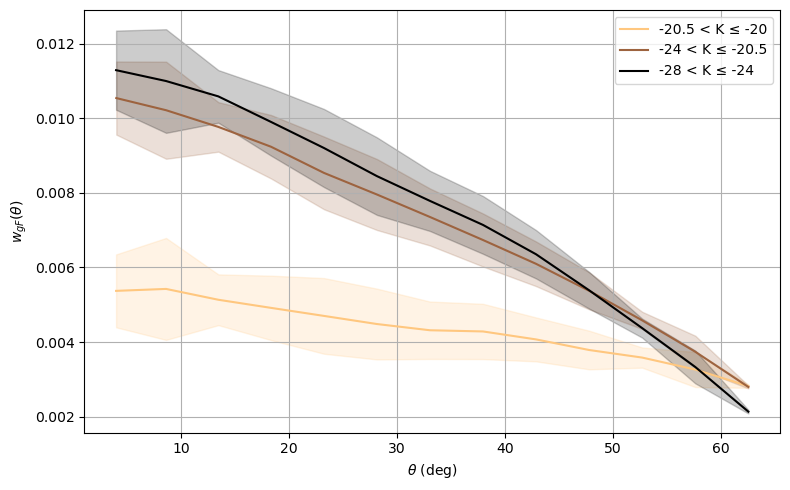

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import treecorr
import healpy as hp
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter


# ============================================================
#  PATCH ESTIMATOR (unchanged)
# ============================================================
def suggest_npatch_from_area(
        area_deg2,
        theta_max_deg,
        N_gal,
        factor=1.5,
        min_per_patch=50,
        verbose=True
    ):
    R_patch = factor * (theta_max_deg/2)
    A_patch = np.pi * R_patch**2

    npatch_ideal = max(1, int(round(area_deg2 / A_patch)))
    npatch_max_from_gal = max(1, N_gal // min_per_patch)

    npatch = max(2, min(npatch_ideal, npatch_max_from_gal))

    if verbose:
        print("----- TreeCorr npatch suggestion -----")
        print(f"Survey area            : {area_deg2:.1f} deg²")
        print(f"Theta max              : {theta_max_deg}°")
        print(f"Patch radius           : {R_patch:.1f}°")
        print(f"Patch area             : {A_patch:.1f} deg²")
        print(f"Ideal npatch (area)    : {npatch_ideal}")
        print(f"Max npatch (gal count) : {npatch_max_from_gal}")
        print(f"Final suggested npatch : {npatch}")
        print(f"Galaxies per patch     : {N_gal/npatch:.1f}")
        print("--------------------------------------")

    return npatch


# ============================================================
#  CATALOG LOADING (unchanged)
# ============================================================
def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    from get_masks import get_milkyway_mask

    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458
    chunksize = 200_000

    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    chunks = []

    for chunk in pd.read_csv(
            filename,
            delim_whitespace=True,
            names=header,
            usecols=cols_to_use,
            skiprows=1,
            chunksize=chunksize
        ):

        chunk = chunk[chunk["dist_flag"] != 0]
        chunk["cz"] = c * chunk["z_cmb"]

        good = (chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)
        chunk = chunk.loc[good]

        chunk["M_K"] = chunk["K"] - 5*np.log10(chunk["d_L"]) - 25
        chunk = chunk[np.isfinite(chunk["M_K"])]

        chunks.append(chunk)

    df = pd.concat(chunks, ignore_index=True)
    df["M_K"] = df["K"] - 5*np.log10(df["d_L"]) - 25
    df = df[df["Dec"] < 45]
    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]

    print(f"Remaining galaxies after all cuts: {len(df)}")
    return df


# ============================================================
#  RANDOM CATALOG GENERATOR (unchanged)
# ============================================================
def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    from get_masks import get_milkyway_mask

    RA = np.random.uniform(0, 360, N_total*3)
    sindec = np.random.uniform(
        np.sin(np.radians(dec_min)),
        np.sin(np.radians(dec_max)),
        N_total*3
    )
    DEC = np.degrees(np.arcsin(sindec))

    mask = get_milkyway_mask(RA, DEC)
    RA, DEC = RA[mask][:N_total], DEC[mask][:N_total]

    if len(RA) < N_total:
        raise ValueError("Not enough random points after masking.")

    return RA, DEC


# ============================================================
#  PLOTTING UTILITIES (unchanged)
# ============================================================
def sky_plot(rand_ra, rand_dec, flux_ra, flux_dec, flux_val, gxs_slice):
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111, projection='hammer')
    ax.grid(True)

    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f"{d}°" for d in xticks_deg])

    yticks_deg = [-75, -45, 0, 45, 75]
    ax.set_yticks(np.radians(yticks_deg))
    ax.set_yticklabels([f"{d}°" for d in yticks_deg])

    norm = colors.Normalize(
        vmin=np.percentile(flux_val, 5),
        vmax=np.percentile(flux_val, 95)
    )
    sc = ax.scatter(
        np.deg2rad(-flux_ra+180.),
        np.deg2rad(flux_dec),
        c=flux_val, s=5,
        cmap='coolwarm', norm=norm,
        edgecolor='none'
    )
    plt.colorbar(sc, ax=ax, orientation='horizontal',
                 pad=0.08, fraction=0.05).set_label("Flux")

    ax.scatter(np.deg2rad(-rand_ra+180.), np.deg2rad(rand_dec),
               s=1, color='k', label='Random')
    ax.scatter(np.deg2rad(-gxs_slice['RA']+180.),
               np.deg2rad(gxs_slice['Dec']),
               s=20, color='C2', label='Galaxies')

    plt.legend()
    plt.show()
    plt.close()


# ============================================================
#  HEALPIX PATCH BOOTSTRAP HELPERS (NEW)
# ============================================================
def healpix_patch_ids(ra, dec, nside):
    """
    Return healpix pixel ids (nest=False) for ra,dec in degrees.
    """
    theta = np.radians(90.0 - dec)
    phi = np.radians(ra)
    pix = hp.ang2pix(nside, theta, phi, nest=False)
    return pix

def build_patch_index_map(patch_ids):
    """
    Map unique patch id -> array of galaxy indices in that patch.
    """
    unique, inv = np.unique(patch_ids, return_inverse=True)
    groups = {u: np.where(inv == i)[0] for i, u in enumerate(unique)}
    return unique, groups

def compute_rk_ref_xi(rand_ra_fixed, rand_dec_fixed, fcat, config):
    """
    Compute a fixed rk.xi array from a large fixed random catalog (used for normalization).
    """
    rcat_ref = treecorr.Catalog(ra=rand_ra_fixed, dec=rand_dec_fixed, ra_units='deg', dec_units='deg')
    rk_ref = treecorr.NKCorrelation(config)
    rk_ref.process(rcat_ref, fcat)
    rk_ref_xi = rk_ref.xi.copy()
    tiny = np.finfo(float).tiny
    rk_ref_xi[rk_ref_xi == 0] = tiny
    return rk_ref_xi


def patch_bootstrap_var_healpix(
        gxs_slice,            # DataFrame with 'RA','Dec'
        fcat,                 # flux TreeCorr catalog (fixed)
        rk_ref_xi,            # array: fixed rk.xi (from fixed random catalog)
        config,
        nside,
        num_bootstrap=500,
        rng=None
    ):
    """
    Patch bootstrap using HEALPix patches. Returns varxi (nbins,).
    """
    if rng is None:
        rng = np.random.default_rng()

    ra = gxs_slice['RA'].values
    dec = gxs_slice['Dec'].values
    Ngal = len(ra)
    nbins = config['nbins']

    # assign healpix pixels
    patch_ids = healpix_patch_ids(ra, dec, nside)
    unique_patches, groups = build_patch_index_map(patch_ids)
    n_patches = len(unique_patches)

    if n_patches < 3:
        raise RuntimeError(f"Too few patches (nside={nside}) -> {n_patches} patches.")

    # precompute list of galaxy indices per patch
    patch_list = [groups[u] for u in unique_patches]

    xi_bs = np.zeros((num_bootstrap, nbins))

    for b in range(num_bootstrap):
        chosen_patch_indices = rng.choice(n_patches, size=n_patches, replace=True)
        sel_indices = np.concatenate([patch_list[i] for i in chosen_patch_indices])

        gbs_ra = ra[sel_indices]
        gbs_dec = dec[sel_indices]
        gcat_bs = treecorr.Catalog(ra=gbs_ra, dec=gbs_dec, ra_units='deg', dec_units='deg')

        nk_bs = treecorr.NKCorrelation(config)
        nk_bs.process(gcat_bs, fcat)

        xi_bs[b, :] = nk_bs.xi / rk_ref_xi - 1.0

    varxi = np.var(xi_bs, axis=0, ddof=1)
    return varxi


# ============================================================
#  MANUAL BOOTSTRAP (kept for reference, but not used below)
# ============================================================
def manual_bootstrap_var(gxs_slice, fcat, rk_ref, config, num_bootstrap=500, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    nbins = config['nbins']
    xi_bs = np.zeros((num_bootstrap, nbins))
    rk_ref_xi = rk_ref.xi.copy()
    tiny = np.finfo(float).tiny
    rk_ref_xi[rk_ref_xi == 0] = tiny

    Ngal = len(gxs_slice)
    idx_all = np.arange(Ngal)

    for i in range(num_bootstrap):
        sel = rng.choice(idx_all, size=Ngal, replace=True)
        gbs = gxs_slice.iloc[sel]

        gcat_bs = treecorr.Catalog(
            ra=gbs['RA'].values, dec=gbs['Dec'].values,
            ra_units='deg', dec_units='deg'
        )

        nk_bs = treecorr.NKCorrelation(config)
        nk_bs.process(gcat_bs, fcat)

        xi_bs[i, :] = nk_bs.xi / rk_ref_xi - 1.0

    return np.var(xi_bs, axis=0, ddof=1)


# ============================================================
#  CORRELATION PIPELINE (uses HEALPix patch-bootstrap)
# ============================================================
def compute_correlation_slice(gxs_slice, rand_ra, rand_dec, fcat, config,
                              bootstrap_method='healpix', nside=16, num_bootstrap=500):
    """
    Compute NK correlation for a single galaxy slice.
    bootstrap_method: 'healpix' or 'point'
    If 'healpix' uses patch_bootstrap_var_healpix with provided nside.
    If 'point' uses manual point-by-point bootstrap (less recommended).
    """
    Ng = len(gxs_slice)
    nrand = len(rand_ra)

    gcat = treecorr.Catalog(
        ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
        ra_units='deg', dec_units='deg'
    )

    rcat = treecorr.Catalog(
        ra=rand_ra[:nrand], dec=rand_dec[:nrand],
        ra_units='deg', dec_units='deg'
    )

    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat, fcat)
    rk.process(rcat, fcat)

    xi_true = nk.xi / rk.xi - 1.0

    # Build a fixed, large random catalog for rk ref (only once per slice)
    rand_ra_fixed, rand_dec_fixed = generate_RanCat(len(gxs_slice) * 100)
    rk_ref_xi = compute_rk_ref_xi(rand_ra_fixed, rand_dec_fixed, fcat, config)

    if bootstrap_method == 'healpix':
        varxi = patch_bootstrap_var_healpix(
            gxs_slice, fcat, rk_ref_xi, config,
            nside=nside, num_bootstrap=num_bootstrap
        )
    else:
        # fallback to point bootstrap (kept for comparison)
        # we create an rk_ref object mimic for manual_bootstrap_var
        rcat_ref = treecorr.Catalog(ra=rand_ra_fixed, dec=rand_dec_fixed, ra_units='deg', dec_units='deg')
        rk_ref = treecorr.NKCorrelation(config)
        rk_ref.process(rcat_ref, fcat)
        varxi = manual_bootstrap_var(gxs_slice, fcat, rk_ref, config, num_bootstrap=num_bootstrap)

    return nk.meanr, xi_true, varxi


# ============================================================
#  MAIN (unchanged logic, but now uses HEALPix bootstrap by default)
# ============================================================
config = dict(
    min_sep=1,
    max_sep=65.,
    nbins=13,
    sep_units='degree',
    bin_type='Linear',
    brute=False,
    metric='Arc',
    var_method='shot',
)

k_slices = [(-20, -20.5), (-20.5, -24), (-24, -28)]
colors_kslices = plt.cm.copper_r(np.linspace(0, 1, len(k_slices)))

# Load data
gxs = read_GLADE(["GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"])
gxs_cz = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 4000)]

flux_cat = np.loadtxt("../data/Auger/flux_a8_lb.dat")
flux_dec, flux_ra, flux_val = flux_cat[:,0], flux_cat[:,1], flux_cat[:,2]

fcat = treecorr.Catalog(
    ra=flux_ra, dec=flux_dec,
    k=flux_val, ra_units='deg', dec_units='deg'
)

nrand = 100
rand_ra, rand_dec = generate_RanCat(len(gxs_cz)*nrand)

# Loop over slices
results = []
# Choose nside and bootstrap samples here:
default_nside = 16        # try 8,16,32 to explore patch sizes
default_nboot = 500

for (k_max, k_min), color in zip(k_slices, colors_kslices):

    print("\nProcessing slice:", k_min, k_max)

    gxs_slice = gxs_cz[
        (gxs_cz['M_K'] > k_min) &
        (gxs_cz['M_K'] <= k_max)
    ]
    Ng = len(gxs_slice)
    print("Galaxies in slice:", Ng)

    meanr, xi, varxi = compute_correlation_slice(
        gxs_slice, rand_ra[:Ng*nrand], rand_dec[:Ng*nrand],
        fcat, config, bootstrap_method='healpix',
        nside=default_nside, num_bootstrap=default_nboot
    )
    results.append((meanr, xi, varxi, f"{k_min} < K ≤ {k_max}", color))


# ============================================================
#  PLOT CORRELATIONS (unchanged)
# ============================================================
plt.figure(figsize=(8, 5))

for meanr, xi, varxi, label, color in results:
    plt.fill_between(meanr, xi - np.sqrt(varxi), xi + np.sqrt(varxi),
                     color=color, alpha=0.2)
    plt.plot(meanr, xi, color=color, label=label)

plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$w_{gF}(\theta)$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('../plots/gal_flux_correlation_k.png', dpi=300)
plt.show()
plt.close()


### Calculate HEALPix patches and feed them to TreeCorr

/tmp/ipykernel_16228/4270250514.py:59: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978
With nside=4, HEALPix pixel effective diameters: 16.54 deg

Processing slice: -20.5 -20
Galaxies in slice: 744
Patch statistics (HEALPix):
  Number of patches              : 3
  Empty patches                  : 0, 0.0%
  Patches with <10 galaxies      : 0, 0.0%
  Mean galaxies per patch        : 248.0
  Median galaxies per patch      : 17.0

Processing slice: -24 -20.5
Galaxies in slice: 4785
Patch statistics (HEALPix):
  Number of patches              : 3
  Empty patches                  : 0, 0.0%
  Patches with <10 galaxies      : 0, 0.0%
  Mean galaxies per patch        : 1595.0
  Median galaxies per patch      : 111.0

Processing slice: -28 -24
Galaxies in slice: 648
Patch statistics (HEALPix):
  Number of patches              : 3
  Empty patches                  : 0, 0.0%
  Patches with <10 galaxies      : 1, 33.3%
  Mean galaxies per patch        : 216.0
  Median galaxies per patch      : 19.0


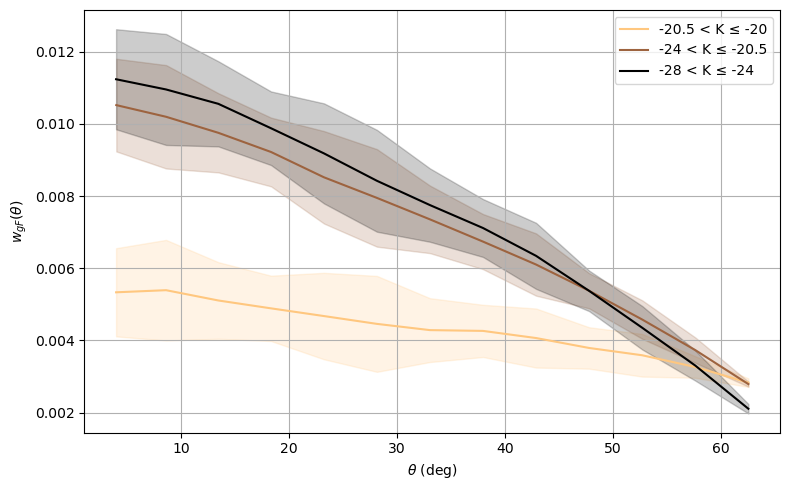

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import treecorr
import healpy as hp
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter


# ============================================================
#  PATCH ESTIMATOR (unchanged)
# ============================================================
def suggest_npatch_from_area(
        area_deg2,
        theta_max_deg,
        N_gal,
        factor=1.5,
        min_per_patch=50,
        verbose=True
    ):
    R_patch = factor * (theta_max_deg/2)
    A_patch = np.pi * R_patch**2

    npatch_ideal = max(1, int(round(area_deg2 / A_patch)))
    npatch_max_from_gal = max(1, N_gal // min_per_patch)

    npatch = max(2, min(npatch_ideal, npatch_max_from_gal))

    if verbose:
        print("----- TreeCorr npatch suggestion -----")
        print(f"Survey area            : {area_deg2:.1f} deg²")
        print(f"Theta max              : {theta_max_deg}°")
        print(f"Patch radius           : {R_patch:.1f}°")
        print(f"Patch area             : {A_patch:.1f} deg²")
        print(f"Ideal npatch (area)    : {npatch_ideal}")
        print(f"Max npatch (gal count) : {npatch_max_from_gal}")
        print(f"Final suggested npatch : {npatch}")
        print(f"Galaxies per patch     : {N_gal/npatch:.1f}")
        print("--------------------------------------")

    return npatch


# ============================================================
#  CATALOG LOADING (unchanged)
# ============================================================
def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    from get_masks import get_milkyway_mask

    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458
    chunksize = 200_000

    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    chunks = []

    for chunk in pd.read_csv(
            filename,
            delim_whitespace=True,
            names=header,
            usecols=cols_to_use,
            skiprows=1,
            chunksize=chunksize
        ):

        chunk = chunk[chunk["dist_flag"] != 0]
        chunk["cz"] = c * chunk["z_cmb"]

        good = (chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)
        chunk = chunk.loc[good]

        chunk["M_K"] = chunk["K"] - 5*np.log10(chunk["d_L"]) - 25
        chunk = chunk[np.isfinite(chunk["M_K"])]

        chunks.append(chunk)

    df = pd.concat(chunks, ignore_index=True)
    df["M_K"] = df["K"] - 5*np.log10(df["d_L"]) - 25
    df = df[df["Dec"] < 45]
    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]

    print(f"Remaining galaxies after all cuts: {len(df)}")
    return df


# ============================================================
#  RANDOM CATALOG GENERATOR (unchanged)
# ============================================================
def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    from get_masks import get_milkyway_mask

    RA = np.random.uniform(0, 360, N_total*3)
    sindec = np.random.uniform(
        np.sin(np.radians(dec_min)),
        np.sin(np.radians(dec_max)),
        N_total*3
    )
    DEC = np.degrees(np.arcsin(sindec))

    mask = get_milkyway_mask(RA, DEC)
    RA, DEC = RA[mask][:N_total], DEC[mask][:N_total]

    if len(RA) < N_total:
        raise ValueError("Not enough random points after masking.")

    return RA, DEC


# ============================================================
#  PLOTTING UTILITIES (unchanged)
# ============================================================
def sky_plot(rand_ra, rand_dec, flux_ra, flux_dec, flux_val, gxs_slice):
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111, projection='hammer')
    ax.grid(True)

    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f"{d}°" for d in xticks_deg])

    yticks_deg = [-75, -45, 0, 45, 75]
    ax.set_yticks(np.radians(yticks_deg))
    ax.set_yticklabels([f"{d}°" for d in yticks_deg])

    norm = colors.Normalize(
        vmin=np.percentile(flux_val, 5),
        vmax=np.percentile(flux_val, 95)
    )
    sc = ax.scatter(
        np.deg2rad(-flux_ra+180.),
        np.deg2rad(flux_dec),
        c=flux_val, s=5,
        cmap='coolwarm', norm=norm,
        edgecolor='none'
    )
    plt.colorbar(sc, ax=ax, orientation='horizontal',
                 pad=0.08, fraction=0.05).set_label("Flux")

    ax.scatter(np.deg2rad(-rand_ra+180.), np.deg2rad(rand_dec),
               s=1, color='k', label='Random')
    ax.scatter(np.deg2rad(-gxs_slice['RA']+180.),
               np.deg2rad(gxs_slice['Dec']),
               s=20, color='C2', label='Galaxies')

    plt.legend()
    plt.show()
    plt.close()


# ============================================================
#  HEALPIX-BASED PATCH BOOTSTRAP FOR TREECORR
#  (Drop-in replacement for TreeCorr's internal patch logic)
# ============================================================

def healpix_patch_ids(ra, dec, nside):
    """Assign HEALPix pixel ids to RA/Dec positions."""
    theta = np.radians(90.0 - dec)
    phi   = np.radians(ra)
    return hp.ang2pix(nside, theta, phi, nest=False)


def build_patch_index_map(patch_ids):
    """
    Convert patch ids → {patch_id : array_of_indices}.
    """
    unique, inv = np.unique(patch_ids, return_inverse=True)
    groups = {u: np.where(inv == i)[0] for i, u in enumerate(unique)}
    return unique, groups


def compute_rk_ref_xi(rand_ra_fixed, rand_dec_fixed, fcat, config):
    """
    Compute RK reference using a very large fixed random catalog.
    This matches TreeCorr's approach for normalizing w = NK/RK - 1.
    """
    rcat_ref = treecorr.Catalog(ra=rand_ra_fixed, dec=rand_dec_fixed,
                                ra_units='deg', dec_units='deg')

    rk_ref = treecorr.NKCorrelation(config)
    rk_ref.process(rcat_ref, fcat)

    rk_ref_xi = rk_ref.xi.copy()
    tiny = np.finfo(float).tiny
    rk_ref_xi[rk_ref_xi == 0] = tiny
    return rk_ref_xi


def patch_bootstrap_var_healpix(
        gxs_slice,
        fcat,
        rk_ref_xi,
        config,
        nside,
        num_bootstrap=500,
        rng=None
    ):
    """
    Patch bootstrap using HEALPix pixels exactly emulating TreeCorr's
    internal patch-bootstrap algorithm.

    Steps:
      1. Assign each galaxy to a HEALPix patch.
      2. Sample patches with replacement (TreeCorr-style).
      3. Concatenate galaxies from selected patches.
      4. Compute NK and normalize with fixed RK_ref.
      5. Repeat → variance.
    """
    if rng is None:
        rng = np.random.default_rng()

    ra  = gxs_slice['RA'].values
    dec = gxs_slice['Dec'].values
    nbins = config['nbins']

    # Assign HEALPix patches
    patch_ids = healpix_patch_ids(ra, dec, nside)
    unique_patches, groups = build_patch_index_map(patch_ids)
    n_patches = len(unique_patches)

    if n_patches < 3:
        raise RuntimeError(f"Too few HEALPix patches ({n_patches}). Increase nside.")

    patch_list = [groups[p] for p in unique_patches]

    # --------------------------------------------
    # HEALPix Patch Occupation Statistics
    # --------------------------------------------

    # Number of patches actually present in the data slice
    n_patches = len(unique_patches)

    # Array of patch sizes (galaxies per patch)
    cpp = np.array([len(groups[p]) for p in unique_patches])

    # Statistics
    cpp_zeros  = np.sum(cpp == 0)         # should be zero by construction
    cpp_lt10   = np.sum(cpp < 10)
    cpp_mean   = np.mean(cpp)
    cpp_median = np.median(cpp)

    print('Patch statistics (HEALPix):')
    print(f'  Number of patches              : {n_patches}')
    print(f'  Empty patches                  : {cpp_zeros}, {cpp_zeros/n_patches*100:.1f}%')
    print(f'  Patches with <10 galaxies      : {cpp_lt10}, {cpp_lt10/n_patches*100:.1f}%')
    print(f'  Mean galaxies per patch        : {cpp_mean:.1f}')
    print(f'  Median galaxies per patch      : {cpp_median:.1f}')
    # --------------------------------------------

    # Storage for bootstrap samples
    xi_bs = np.zeros((num_bootstrap, nbins))

    for b in range(num_bootstrap):
        # Select patches with replacement
        chosen = rng.choice(n_patches, size=n_patches, replace=True)

        # The bootstrap galaxy sample = concatenation of those patches
        indices = np.concatenate([patch_list[i] for i in chosen])
        g_ra  = ra[indices]
        g_dec = dec[indices]

        gcat_bs = treecorr.Catalog(ra=g_ra, dec=g_dec,
                                   ra_units='deg', dec_units='deg')

        nk_bs = treecorr.NKCorrelation(config)
        nk_bs.process(gcat_bs, fcat)

        xi_bs[b, :] = nk_bs.xi / rk_ref_xi - 1.0

    return np.var(xi_bs, axis=0, ddof=1)

# ============================================================
#  CORRELATION PIPELINE (uses HEALPix patch-bootstrap)
# ============================================================
def compute_correlation_slice(gxs_slice, rand_ra, rand_dec, fcat, config,
                              bootstrap_method='healpix', nside=16, num_bootstrap=500):
    """
    Compute NK correlation for a single galaxy slice.
    bootstrap_method: 'healpix' or 'point'
    If 'healpix' uses patch_bootstrap_var_healpix with provided nside.
    If 'point' uses manual point-by-point bootstrap (less recommended).
    """
    Ng = len(gxs_slice)
    nrand = len(rand_ra)

    gcat = treecorr.Catalog(
        ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
        ra_units='deg', dec_units='deg'
    )

    rcat = treecorr.Catalog(
        ra=rand_ra[:nrand], dec=rand_dec[:nrand],
        ra_units='deg', dec_units='deg'
    )

    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat, fcat)
    rk.process(rcat, fcat)

    xi_true = nk.xi / rk.xi - 1.0

    # Build a fixed, large random catalog for rk ref (only once per slice)
    rand_ra_fixed, rand_dec_fixed = generate_RanCat(len(gxs_slice) * 100)
    rk_ref_xi = compute_rk_ref_xi(rand_ra_fixed, rand_dec_fixed, fcat, config)

    if bootstrap_method == 'healpix':
        varxi = patch_bootstrap_var_healpix(
            gxs_slice, fcat, rk_ref_xi, config,
            nside=nside, num_bootstrap=num_bootstrap
        )

    else:
        # fallback to point bootstrap (kept for comparison)
        # we create an rk_ref object mimic for manual_bootstrap_var
        rcat_ref = treecorr.Catalog(ra=rand_ra_fixed, dec=rand_dec_fixed, ra_units='deg', dec_units='deg')
        rk_ref = treecorr.NKCorrelation(config)
        rk_ref.process(rcat_ref, fcat)
        varxi = manual_bootstrap_var(gxs_slice, fcat, rk_ref, config, num_bootstrap=num_bootstrap)

    return nk.meanr, xi_true, varxi


# ============================================================
#  MAIN (unchanged logic, but now uses HEALPix bootstrap by default)
# ============================================================
config = dict(
    min_sep=1,
    max_sep=65.,
    nbins=13,
    sep_units='degree',
    bin_type='Linear',
    brute=False,
    metric='Arc',
    var_method='shot',
)

k_slices = [(-20, -20.5), (-20.5, -24), (-24, -28)]
colors_kslices = plt.cm.copper_r(np.linspace(0, 1, len(k_slices)))

# Load data
gxs = read_GLADE(["GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"])
gxs_cz = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 4000)]

flux_cat = np.loadtxt("../data/Auger/flux_a8_lb.dat")
flux_dec, flux_ra, flux_val = flux_cat[:,0], flux_cat[:,1], flux_cat[:,2]

fcat = treecorr.Catalog(
    ra=flux_ra, dec=flux_dec,
    k=flux_val, ra_units='deg', dec_units='deg'
)

nrand = 100
rand_ra, rand_dec = generate_RanCat(len(gxs_cz)*nrand)

# Loop over slices
results = []
# Choose nside and bootstrap samples here:
default_nside = 4       # try 8,16,32 to explore patch sizes
default_nboot = 500
import numpy as np
import healpy as hp

def pixel_effective_diameter_deg(nside):
    """
    Effective pixel diameter = diameter of a circle having the same area
    as a HEALPix pixel at this nside.
    """
    # equal-area HEALPix pixel area in steradians
    area_sr = hp.nside2pixarea(nside)

    # convert to deg²
    area_deg2 = area_sr * (180/np.pi)**2

    # effective radius (deg)
    R_deg = np.sqrt(area_deg2 / np.pi)

    # effective diameter
    return 2 * R_deg

print(f"With nside={default_nside}, HEALPix pixel effective diameters: {pixel_effective_diameter_deg(default_nside):.2f} deg")

for (k_max, k_min), color in zip(k_slices, colors_kslices):

    print("\nProcessing slice:", k_min, k_max)

    gxs_slice = gxs_cz[
        (gxs_cz['M_K'] > k_min) &
        (gxs_cz['M_K'] <= k_max)
    ]
    Ng = len(gxs_slice)
    print("Galaxies in slice:", Ng)

    meanr, xi, varxi = compute_correlation_slice(
        gxs_slice, rand_ra[:Ng*nrand], rand_dec[:Ng*nrand],
        fcat, config, bootstrap_method='healpix',
        nside=default_nside, num_bootstrap=default_nboot
    )
    results.append((meanr, xi, varxi, f"{k_min} < K ≤ {k_max}", color))


# ============================================================
#  PLOT CORRELATIONS (unchanged)
# ============================================================
plt.figure(figsize=(8, 5))

for meanr, xi, varxi, label, color in results:
    plt.fill_between(meanr, xi - np.sqrt(varxi), xi + np.sqrt(varxi),
                     color=color, alpha=0.2)
    plt.plot(meanr, xi, color=color, label=label)

plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$w_{gF}(\theta)$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('../plots/gal_flux_correlation_k.png', dpi=300)
plt.show()
plt.close()


### KMeans patching

/tmp/ipykernel_16228/3855255607.py:97: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978
With nside=4, HEALPix pixel effective diameters: 16.54 deg

Processing slice: -20.5 -20
Galaxies in slice: 744
Using k-means with npatch=37 for Ng=744 (min=30)
Patch statistics (KMeans):
  Number of patches              : 37
  Empty patches                  : 0, 0.0%
  Patches with <10 galaxies      : 6, 16.2%
  Mean galaxies per patch        : 20.1
  Median galaxies per patch      : 18.0

Processing slice: -24 -20.5
Galaxies in slice: 4785
Using k-means with npatch=239 for Ng=4785 (min=30)
Patch statistics (KMeans):
  Number of patches              : 239
  Empty patches                  : 0, 0.0%
  Patches with <10 galaxies      : 50, 20.9%
  Mean galaxies per patch        : 20.0
  Median galaxies per patch      : 17.0

Processing slice: -28 -24
Galaxies in slice: 648
Using k-means with npatch=32 for Ng=648 (min=30)
Patch statistics (KMeans):
  Number of patches              : 32
  Empty patches                  : 0, 0.0%
  Patches with <10 ga

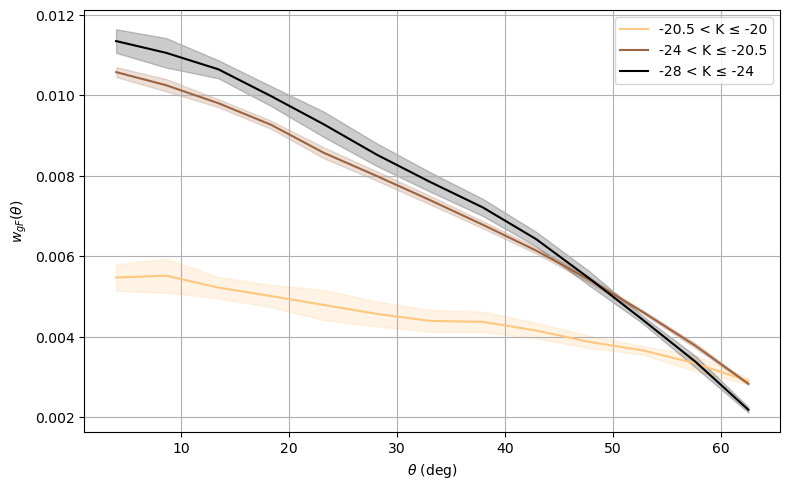

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import treecorr
import healpy as hp
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter

def kmeans_patch_ids(ra, dec, npatch, random_state=123):
    """
    Assign k-means patches to RA/Dec positions.
    Inputs in degrees. Output is patch_id for each point.
    Clustering is done in 3D unit-vector space on the sphere 
    to avoid RA wrap and Euclidean distortion.
    """
    # Convert to unit vectors
    theta = np.radians(90.0 - dec)
    phi   = np.radians(ra)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    coords = np.vstack([x, y, z]).T

    km = KMeans(n_clusters=npatch, n_init='auto', random_state=random_state)
    labels = km.fit_predict(coords)

    return labels

def print_patch_stats(patch_ids):
    unique, counts = np.unique(patch_ids, return_counts=True)
    n_patches = len(unique)
    cpp = counts

    cpp_zeros  = np.sum(cpp == 0)
    cpp_lt10   = np.sum(cpp < 10)
    cpp_mean   = np.mean(cpp)
    cpp_median = np.median(cpp)

    print('Patch statistics (KMeans):')
    print(f'  Number of patches              : {n_patches}')
    print(f'  Empty patches                  : {cpp_zeros}, {cpp_zeros/n_patches*100:.1f}%')
    print(f'  Patches with <10 galaxies      : {cpp_lt10}, {cpp_lt10/n_patches*100:.1f}%')
    print(f'  Mean galaxies per patch        : {cpp_mean:.1f}')
    print(f'  Median galaxies per patch      : {cpp_median:.1f}')


# ============================================================
#  PATCH ESTIMATOR (unchanged)
# ============================================================
def suggest_npatch_from_area(
        area_deg2,
        theta_max_deg,
        N_gal,
        factor=1.5,
        min_per_patch=50,
        verbose=True
    ):
    R_patch = factor * (theta_max_deg/2)
    A_patch = np.pi * R_patch**2

    npatch_ideal = max(1, int(round(area_deg2 / A_patch)))
    npatch_max_from_gal = max(1, N_gal // min_per_patch)

    npatch = max(2, min(npatch_ideal, npatch_max_from_gal))

    if verbose:
        print("----- TreeCorr npatch suggestion -----")
        print(f"Survey area            : {area_deg2:.1f} deg²")
        print(f"Theta max              : {theta_max_deg}°")
        print(f"Patch radius           : {R_patch:.1f}°")
        print(f"Patch area             : {A_patch:.1f} deg²")
        print(f"Ideal npatch (area)    : {npatch_ideal}")
        print(f"Max npatch (gal count) : {npatch_max_from_gal}")
        print(f"Final suggested npatch : {npatch}")
        print(f"Galaxies per patch     : {N_gal/npatch:.1f}")
        print("--------------------------------------")

    return npatch


# ============================================================
#  CATALOG LOADING (unchanged)
# ============================================================
def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    from get_masks import get_milkyway_mask

    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458
    chunksize = 200_000

    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    chunks = []

    for chunk in pd.read_csv(
            filename,
            delim_whitespace=True,
            names=header,
            usecols=cols_to_use,
            skiprows=1,
            chunksize=chunksize
        ):

        chunk = chunk[chunk["dist_flag"] != 0]
        chunk["cz"] = c * chunk["z_cmb"]

        good = (chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)
        chunk = chunk.loc[good]

        chunk["M_K"] = chunk["K"] - 5*np.log10(chunk["d_L"]) - 25
        chunk = chunk[np.isfinite(chunk["M_K"])]

        chunks.append(chunk)

    df = pd.concat(chunks, ignore_index=True)
    df["M_K"] = df["K"] - 5*np.log10(df["d_L"]) - 25
    df = df[df["Dec"] < 45]
    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]

    print(f"Remaining galaxies after all cuts: {len(df)}")
    return df


# ============================================================
#  RANDOM CATALOG GENERATOR (unchanged)
# ============================================================
def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    from get_masks import get_milkyway_mask

    RA = np.random.uniform(0, 360, N_total*3)
    sindec = np.random.uniform(
        np.sin(np.radians(dec_min)),
        np.sin(np.radians(dec_max)),
        N_total*3
    )
    DEC = np.degrees(np.arcsin(sindec))

    mask = get_milkyway_mask(RA, DEC)
    RA, DEC = RA[mask][:N_total], DEC[mask][:N_total]

    if len(RA) < N_total:
        raise ValueError("Not enough random points after masking.")

    return RA, DEC


# ============================================================
#  PLOTTING UTILITIES (unchanged)
# ============================================================
def sky_plot(rand_ra, rand_dec, flux_ra, flux_dec, flux_val, gxs_slice):
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111, projection='hammer')
    ax.grid(True)

    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f"{d}°" for d in xticks_deg])

    yticks_deg = [-75, -45, 0, 45, 75]
    ax.set_yticks(np.radians(yticks_deg))
    ax.set_yticklabels([f"{d}°" for d in yticks_deg])

    norm = colors.Normalize(
        vmin=np.percentile(flux_val, 5),
        vmax=np.percentile(flux_val, 95)
    )
    sc = ax.scatter(
        np.deg2rad(-flux_ra+180.),
        np.deg2rad(flux_dec),
        c=flux_val, s=5,
        cmap='coolwarm', norm=norm,
        edgecolor='none'
    )
    plt.colorbar(sc, ax=ax, orientation='horizontal',
                 pad=0.08, fraction=0.05).set_label("Flux")

    ax.scatter(np.deg2rad(-rand_ra+180.), np.deg2rad(rand_dec),
               s=1, color='k', label='Random')
    ax.scatter(np.deg2rad(-gxs_slice['RA']+180.),
               np.deg2rad(gxs_slice['Dec']),
               s=20, color='C2', label='Galaxies')

    plt.legend()
    plt.show()
    plt.close()


# ============================================================
#  HEALPIX-BASED PATCH BOOTSTRAP FOR TREECORR
#  (Drop-in replacement for TreeCorr's internal patch logic)
# ============================================================

def healpix_patch_ids(ra, dec, nside):
    """Assign HEALPix pixel ids to RA/Dec positions."""
    theta = np.radians(90.0 - dec)
    phi   = np.radians(ra)
    return hp.ang2pix(nside, theta, phi, nest=False)


def build_patch_index_map(patch_ids):
    """
    Convert patch ids → {patch_id : array_of_indices}.
    """
    unique, inv = np.unique(patch_ids, return_inverse=True)
    groups = {u: np.where(inv == i)[0] for i, u in enumerate(unique)}
    return unique, groups


def compute_rk_ref_xi(rand_ra_fixed, rand_dec_fixed, fcat, config):
    """
    Compute RK reference using a very large fixed random catalog.
    This matches TreeCorr's approach for normalizing w = NK/RK - 1.
    """
    rcat_ref = treecorr.Catalog(ra=rand_ra_fixed, dec=rand_dec_fixed,
                                ra_units='deg', dec_units='deg')

    rk_ref = treecorr.NKCorrelation(config)
    rk_ref.process(rcat_ref, fcat)

    rk_ref_xi = rk_ref.xi.copy()
    tiny = np.finfo(float).tiny
    rk_ref_xi[rk_ref_xi == 0] = tiny
    return rk_ref_xi


def patch_bootstrap_var_healpix(
        gxs_slice,
        fcat,
        rk_ref_xi,
        config,
        nside,
        num_bootstrap=500,
        rng=None
    ):
    """
    Patch bootstrap using HEALPix pixels exactly emulating TreeCorr's
    internal patch-bootstrap algorithm.

    Steps:
      1. Assign each galaxy to a HEALPix patch.
      2. Sample patches with replacement (TreeCorr-style).
      3. Concatenate galaxies from selected patches.
      4. Compute NK and normalize with fixed RK_ref.
      5. Repeat → variance.
    """
    if rng is None:
        rng = np.random.default_rng()

    ra  = gxs_slice['RA'].values
    dec = gxs_slice['Dec'].values
    nbins = config['nbins']

    # Assign HEALPix patches
    patch_ids = healpix_patch_ids(ra, dec, nside)
    unique_patches, groups = build_patch_index_map(patch_ids)
    n_patches = len(unique_patches)

    if n_patches < 3:
        raise RuntimeError(f"Too few HEALPix patches ({n_patches}). Increase nside.")

    patch_list = [groups[p] for p in unique_patches]

    # --------------------------------------------
    # HEALPix Patch Occupation Statistics
    # --------------------------------------------

    # Number of patches actually present in the data slice
    n_patches = len(unique_patches)

    # Array of patch sizes (galaxies per patch)
    cpp = np.array([len(groups[p]) for p in unique_patches])

    # Statistics
    cpp_zeros  = np.sum(cpp == 0)         # should be zero by construction
    cpp_lt10   = np.sum(cpp < 10)
    cpp_mean   = np.mean(cpp)
    cpp_median = np.median(cpp)

    print('Patch statistics (HEALPix):')
    print(f'  Number of patches              : {n_patches}')
    print(f'  Empty patches                  : {cpp_zeros}, {cpp_zeros/n_patches*100:.1f}%')
    print(f'  Patches with <10 galaxies      : {cpp_lt10}, {cpp_lt10/n_patches*100:.1f}%')
    print(f'  Mean galaxies per patch        : {cpp_mean:.1f}')
    print(f'  Median galaxies per patch      : {cpp_median:.1f}')
    # --------------------------------------------

    # Storage for bootstrap samples
    xi_bs = np.zeros((num_bootstrap, nbins))

    for b in range(num_bootstrap):
        # Select patches with replacement
        chosen = rng.choice(n_patches, size=n_patches, replace=True)

        # The bootstrap galaxy sample = concatenation of those patches
        indices = np.concatenate([patch_list[i] for i in chosen])
        g_ra  = ra[indices]
        g_dec = dec[indices]

        gcat_bs = treecorr.Catalog(ra=g_ra, dec=g_dec,
                                   ra_units='deg', dec_units='deg')

        nk_bs = treecorr.NKCorrelation(config)
        nk_bs.process(gcat_bs, fcat)

        xi_bs[b, :] = nk_bs.xi / rk_ref_xi - 1.0

    return np.var(xi_bs, axis=0, ddof=1)

def patch_bootstrap_var_kmeans(
        gxs_slice,
        fcat,
        rk_ref_xi,
        config,
        npatch,
        num_bootstrap=500,
        rng=None,
        random_state=123
    ):
    """
    Patch bootstrap using k-means patches (equal-occupancy-ish).
    Steps match your HEALPix version except for patch assignment.
    """

    if rng is None:
        rng = np.random.default_rng()

    ra  = gxs_slice['RA'].values
    dec = gxs_slice['Dec'].values
    nbins = config['nbins']
    Ng = len(ra)

    # ----------------------
    # Assign KMeans patches
    # ----------------------
    patch_ids = kmeans_patch_ids(ra, dec, npatch, random_state=random_state)

    # Group indices per patch
    unique_patches = np.unique(patch_ids)
    groups = {p: np.where(patch_ids == p)[0] for p in unique_patches}
    patch_list = [groups[p] for p in unique_patches]
    n_patches = len(unique_patches)

    if n_patches < 3:
        raise RuntimeError(f"Too few k-means patches ({n_patches}). Reduce npatch.")

    # Print patch statistics
    print_patch_stats(patch_ids)

    # ----------------------
    # Bootstrap
    # ----------------------
    xi_bs = np.zeros((num_bootstrap, nbins))

    for b in range(num_bootstrap):
        chosen = rng.choice(n_patches, size=n_patches, replace=True)
        indices = np.concatenate([patch_list[i] for i in chosen])

        gcat_bs = treecorr.Catalog(
            ra=ra[indices], dec=dec[indices],
            ra_units='deg', dec_units='deg'
        )

        nk_bs = treecorr.NKCorrelation(config)
        nk_bs.process(gcat_bs, fcat)

        xi_bs[b,:] = nk_bs.xi / rk_ref_xi - 1.0

    return np.var(xi_bs, axis=0, ddof=1)

# ============================================================
#  CORRELATION PIPELINE (uses HEALPix patch-bootstrap)
# ============================================================
def compute_correlation_slice(gxs_slice, rand_ra, rand_dec, fcat, config,
                              bootstrap_method='healpix', nside=16, num_bootstrap=500):
    """
    Compute NK correlation for a single galaxy slice.
    bootstrap_method: 'healpix' or 'point'
    If 'healpix' uses patch_bootstrap_var_healpix with provided nside.
    If 'point' uses manual point-by-point bootstrap (less recommended).
    """
    Ng = len(gxs_slice)
    nrand = len(rand_ra)

    gcat = treecorr.Catalog(
        ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
        ra_units='deg', dec_units='deg'
    )

    rcat = treecorr.Catalog(
        ra=rand_ra[:nrand], dec=rand_dec[:nrand],
        ra_units='deg', dec_units='deg'
    )

    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat, fcat)
    rk.process(rcat, fcat)

    xi_true = nk.xi / rk.xi - 1.0

    # Build a fixed, large random catalog for rk ref (only once per slice)
    rand_ra_fixed, rand_dec_fixed = generate_RanCat(len(gxs_slice) * 100)
    rk_ref_xi = compute_rk_ref_xi(rand_ra_fixed, rand_dec_fixed, fcat, config)

    target_min_per_patch = 20
    npatch = max(30, Ng // target_min_per_patch)
    print(f"Using k-means with npatch={npatch} for Ng={Ng} (min=30)")

    if bootstrap_method == 'healpix':
        varxi = patch_bootstrap_var_healpix(
            gxs_slice, fcat, rk_ref_xi, config,
            nside=nside, num_bootstrap=num_bootstrap
        )

    if bootstrap_method == 'kmeans':
        # determine npatch per-slice
        target_min_per_patch = 20
        npatch = max(30, Ng // target_min_per_patch)


        varxi = patch_bootstrap_var_kmeans(
            gxs_slice, fcat, rk_ref_xi, config,
            npatch=npatch,
            num_bootstrap=num_bootstrap
        )


    else:
        # fallback to point bootstrap (kept for comparison)
        # we create an rk_ref object mimic for manual_bootstrap_var
        rcat_ref = treecorr.Catalog(ra=rand_ra_fixed, dec=rand_dec_fixed, ra_units='deg', dec_units='deg')
        rk_ref = treecorr.NKCorrelation(config)
        rk_ref.process(rcat_ref, fcat)
        varxi = manual_bootstrap_var(gxs_slice, fcat, rk_ref, config, num_bootstrap=num_bootstrap)

    return nk.meanr, xi_true, varxi


# ============================================================
#  MAIN (unchanged logic, but now uses HEALPix bootstrap by default)
# ============================================================
config = dict(
    min_sep=1,
    max_sep=65.,
    nbins=13,
    sep_units='degree',
    bin_type='Linear',
    brute=False,
    metric='Arc',
    var_method='shot',
)

k_slices = [(-20, -20.5), (-20.5, -24), (-24, -28)]
colors_kslices = plt.cm.copper_r(np.linspace(0, 1, len(k_slices)))

# Load data
gxs = read_GLADE(["GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"])
gxs_cz = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 4000)]

flux_cat = np.loadtxt("../data/Auger/flux_a8_lb.dat")
flux_dec, flux_ra, flux_val = flux_cat[:,0], flux_cat[:,1], flux_cat[:,2]

fcat = treecorr.Catalog(
    ra=flux_ra, dec=flux_dec,
    k=flux_val, ra_units='deg', dec_units='deg'
)

nrand = 100
rand_ra, rand_dec = generate_RanCat(len(gxs_cz)*nrand)

# Loop over slices
results = []
# Choose nside and bootstrap samples here:
default_nside = 4       # try 8,16,32 to explore patch sizes
default_nboot = 500
import numpy as np
import healpy as hp
from sklearn.cluster import KMeans

def pixel_effective_diameter_deg(nside):
    """
    Effective pixel diameter = diameter of a circle having the same area
    as a HEALPix pixel at this nside.
    """
    # equal-area HEALPix pixel area in steradians
    area_sr = hp.nside2pixarea(nside)

    # convert to deg²
    area_deg2 = area_sr * (180/np.pi)**2

    # effective radius (deg)
    R_deg = np.sqrt(area_deg2 / np.pi)

    # effective diameter
    return 2 * R_deg

print(f"With nside={default_nside}, HEALPix pixel effective diameters: {pixel_effective_diameter_deg(default_nside):.2f} deg")

for (k_max, k_min), color in zip(k_slices, colors_kslices):

    print("\nProcessing slice:", k_min, k_max)

    gxs_slice = gxs_cz[
        (gxs_cz['M_K'] > k_min) &
        (gxs_cz['M_K'] <= k_max)
    ]
    Ng = len(gxs_slice)
    print("Galaxies in slice:", Ng)

    meanr, xi, varxi = compute_correlation_slice(
        gxs_slice, rand_ra[:Ng*nrand], rand_dec[:Ng*nrand],
        fcat, config, bootstrap_method='kmeans',
        nside=default_nside, num_bootstrap=default_nboot
    )
    results.append((meanr, xi, varxi, f"{k_min} < K ≤ {k_max}", color))


# ============================================================
#  PLOT CORRELATIONS (unchanged)
# ============================================================
plt.figure(figsize=(8, 5))

for meanr, xi, varxi, label, color in results:
    plt.fill_between(meanr, xi - np.sqrt(varxi), xi + np.sqrt(varxi),
                     color=color, alpha=0.2)
    plt.plot(meanr, xi, color=color, label=label)

plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$w_{gF}(\theta)$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('../plots/gal_flux_correlation_k.png', dpi=300)
plt.show()
plt.close()


### LEt's take a couple of steps back

/tmp/ipykernel_30405/1304783677.py:133: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Galaxies after masks: 116978

Processing slice: -20.5 -20
Galaxies in slice: 744
Patch statistics:
  Number of patches       : 25
  Empty patches          : 0, 0.0%
  Patches with <10 gxs   : 0 , 0.0%
  Mean gxs per patch     : 29.8
  Median gxs per patch   : 25.0
ang_dist percentiles (deg): [ 0.46629503  1.53322265  2.60605911  6.59813616  9.97297393 15.05596073
 20.59900632 24.92696644 29.90593802]
max ang_dist (deg): 29.905938018687557
fraction > 90 deg: 0.0
  Mean patch radius     : 11.22°
  Median patch radius   : 11.41°

Processing slice: -24 -20.5
Galaxies in slice: 4785
Patch statistics:
  Number of patches       : 25
  Empty patches          : 0, 0.0%
  Patches with <10 gxs   : 0 , 0.0%
  Mean gxs per patch     : 191.4
  Median gxs per patch   : 170.0
ang_dist percentiles (deg): [ 0.10838684  1.24549472  2.77839511  6.56239834 10.5507064  14.54446347
 21.04489163 26.5052721  30.94891187]
max ang_dist (deg): 30.948911868678827
fraction > 90 deg: 0.0
  Mean patch radius     : 11

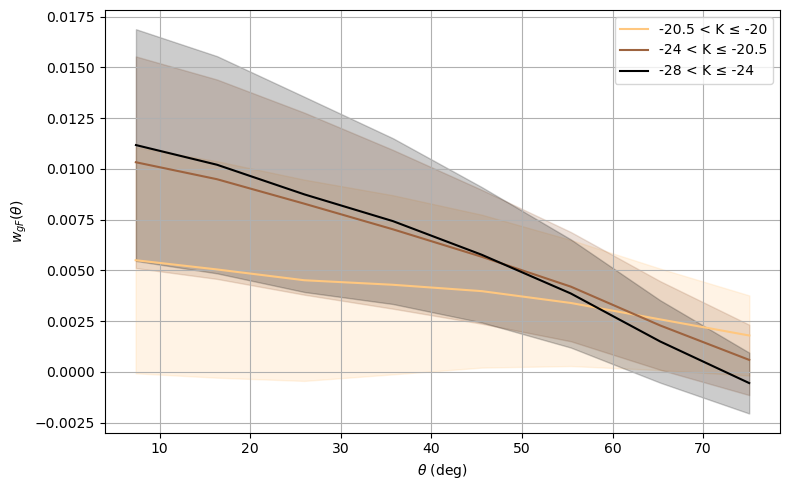

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import treecorr
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter

import numpy as np
from sklearn.cluster import KMeans

def make_nonempty_kmeans_patches(ra_deg, dec_deg, N_patches, random_state=123):
    """
    Create exactly N non-empty patches for TreeCorr by applying k-means 
    clustering to (RA, Dec) positions on the sphere.

    Parameters
    ----------
    ra_deg : array-like
        Right ascension in degrees.
    dec_deg : array-like
        Declination in degrees.
    N_patches : int
        Desired number of non-empty patches. Must satisfy N_patches <= N_points.
    random_state : int
        Seed for reproducible clustering.

    Returns
    -------
    patch_index : np.ndarray of shape (N_points,)
        Integer patch index for each point, guaranteed to be in [0, N_patches-1],
        and guaranteed that each patch has at least 1 point.
    """

    ra_deg = np.asarray(ra_deg)
    dec_deg = np.asarray(dec_deg)
    N_points = len(ra_deg)

    if N_patches > N_points:
        raise ValueError(f"N_patches={N_patches} but only {N_points} points available.")

    # Convert to 3D unit vectors for proper spherical k-means
    ra_rad  = np.deg2rad(ra_deg)
    dec_rad = np.deg2rad(dec_deg)
    x = np.cos(dec_rad) * np.cos(ra_rad)
    y = np.cos(dec_rad) * np.sin(ra_rad)
    z = np.sin(dec_rad)
    coords = np.column_stack([x, y, z])

    # Run k-means clustering
    kmeans = KMeans(
        n_clusters=N_patches,
        n_init=10,
        random_state=random_state
    ).fit(coords)

    labels = kmeans.labels_

    # Sanity check: ensure all patches are non-empty
    unique, counts = np.unique(labels, return_counts=True)
    if np.any(counts == 0):
        raise RuntimeError("A k-means patch came out empty. This should not happen unless data is degenerate.")

    return labels

# ============================================================
#  PATCH ESTIMATOR
# ============================================================

def suggest_npatch_from_area(
        area_deg2,
        theta_max_deg,
        N_gal,
        factor=1.,
        min_per_patch=0,
        verbose=True
    ):
    """
    Suggest TreeCorr npatch using:
      - geometric scale: patch radius > theta_max
      - survey area constraint
      - minimum galaxies/patch constraint
    """

    R_patch = factor * (theta_max_deg/2)
    A_patch = np.pi * R_patch**2

    npatch_ideal = max(1, int(round(area_deg2 / A_patch)))
    if min_per_patch!=0: 
        npatch_max_from_gal = max(1, N_gal // min_per_patch)

        # Final choice
        npatch = max(2, min(npatch_ideal, npatch_max_from_gal))
    
    else:
        npatch = max(2, npatch_ideal)
        npatch_max_from_gal = None

    if verbose:
        print("----- TreeCorr npatch suggestion -----")
        #print(f"Survey area            : {area_deg2:.1f} deg²")
        #print(f"Theta max              : {theta_max_deg}°")
        #print(f"Patch radius           : {R_patch:.1f}°")
        #print(f"Patch area             : {A_patch:.1f} deg²")
        print(f"Ideal npatch (area)    : {npatch_ideal}")
        print(f"Max npatch (gal count) : {npatch_max_from_gal}")
        print(f"Final suggested npatch : {npatch}")
        #print(f"Galaxies per patch     : {N_gal/npatch:.1f}")
        print("--------------------------------------")

    return npatch


# ============================================================
#  CATALOG LOADING
# ============================================================

def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    """
    Load and filter GLADE catalog in chunks for memory efficiency.
    """
    from get_masks import get_milkyway_mask

    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458
    chunksize = 200_000

    # Load header
    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    chunks = []

    for chunk in pd.read_csv(
            filename,
            delim_whitespace=True,
            names=header,
            usecols=cols_to_use,
            skiprows=1,
            chunksize=chunksize
        ):

        chunk = chunk[chunk["dist_flag"] != 0]   # Remove missing redshifts
        chunk["cz"] = c * chunk["z_cmb"]

        # Physical cuts
        good = (chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)
        chunk = chunk.loc[good]

        # Compute M_K
        chunk["M_K"] = chunk["K"] - 5*np.log10(chunk["d_L"]) - 25
        chunk = chunk[np.isfinite(chunk["M_K"])]

        chunks.append(chunk)

    df = pd.concat(chunks, ignore_index=True)

    df["M_K"] = df["K"] - 5.*np.log10(df["d_L"]) - 25.
    df = df[df["Dec"] < 45.]  # survey cut
    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]

    print(f"Galaxies after masks: {len(df)}")
    return df


# ============================================================
#  RANDOM CATALOG GENERATOR
# ============================================================

def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    """
    Generate random RA/Dec respecting declination limits and MW mask.
    """
    from get_masks import get_milkyway_mask

    # Draw more points than needed
    RA = np.random.uniform(0, 360, N_total*3)
    sindec = np.random.uniform(
        np.sin(np.radians(dec_min)),
        np.sin(np.radians(dec_max)),
        N_total*3
    )
    DEC = np.degrees(np.arcsin(sindec))

    mask = get_milkyway_mask(RA, DEC)
    RA, DEC = RA[mask][:N_total], DEC[mask][:N_total]

    if len(RA) < N_total:
        raise ValueError("Not enough random points after masking.")

    return RA, DEC


# ============================================================
#  PLOTTING UTILITIES
# ============================================================

def sky_plot(rand_ra, rand_dec, flux_ra, flux_dec, flux_val, gxs_slice):
    """
    Hammer projection plot of randoms, flux, and galaxy positions.
    """
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111, projection='hammer')
    ax.grid(True)

    # X ticks
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f"{d}°" for d in xticks_deg])

    # Y ticks
    yticks_deg = [-75, -45, 0, 45, 75]
    ax.set_yticks(np.radians(yticks_deg))
    ax.set_yticklabels([f"{d}°" for d in yticks_deg])

    # Flux map
    norm = colors.Normalize(
        vmin=np.percentile(flux_val, 5),
        vmax=np.percentile(flux_val, 95)
    )
    sc = ax.scatter(
        np.deg2rad(-flux_ra+180.),
        np.deg2rad(flux_dec),
        c=flux_val, s=5,
        cmap='coolwarm', norm=norm,
        edgecolor='none'
    )
    plt.colorbar(sc, ax=ax, orientation='horizontal',
                 pad=0.08, fraction=0.05).set_label("Flux")

    # Randoms and galaxies
    ax.scatter(np.deg2rad(-rand_ra+180.), np.deg2rad(rand_dec),
               s=1, color='k', label='Random')
    ax.scatter(np.deg2rad(-gxs_slice['RA']+180.),
               np.deg2rad(gxs_slice['Dec']),
               s=20, color='C2', label='Galaxies')

    plt.legend()
    plt.show()
    plt.close()


# ============================================================
#  CORRELATION PIPELINE
# ============================================================

def compute_correlation_slice(gxs_slice, rand_ra, rand_dec, fcat, config, npatch):
    """
    Compute NK correlation for single galaxy slice.
    """
    Ng = len(gxs_slice)
    nrand = len(rand_ra)

    patch = make_nonempty_kmeans_patches(gxs_slice['RA'], gxs_slice['Dec'], N_patches=npatch)

    gcat = treecorr.Catalog(
        ra=gxs_slice['RA'], dec=gxs_slice['Dec'],
        ra_units='deg', dec_units='deg',
        patch=patch
    )
    rcat = treecorr.Catalog(
        ra=rand_ra[:nrand], dec=rand_dec[:nrand],
        ra_units='deg', dec_units='deg',
        patch_centers=gcat.patch_centers
    )

    # See patch occupation statistics
    n_patches = len(gcat.patch_centers)
    cpp = np.bincount(gcat.patch, minlength=n_patches) # counts per patch
    cpp_zeros = np.sum(cpp == 0)
    cpp_lt10 = np.sum(cpp < 10)
    cpp_mean, cpp_median = np.mean(cpp), np.median(cpp)
    print('Patch statistics:')
    print(f'  Number of patches       : {n_patches}')
    print(f'  Empty patches          : {cpp_zeros}, {cpp_zeros/n_patches*100:.1f}%')
    print(f'  Patches with <10 gxs   : {cpp_lt10}', f', {cpp_lt10/n_patches*100:.1f}%')
    print(f'  Mean gxs per patch     : {cpp_mean:.1f}')
    print(f'  Median gxs per patch   : {cpp_median:.1f}')

    # ----- FIX: compute patch centers from kmeans (consistent with 'patch') -----
    # Recompute centers from labels (patch) using 3D mean (spherical centroid)
    ra_arr = np.deg2rad(gxs_slice['RA'].values)
    dec_arr = np.deg2rad(gxs_slice['Dec'].values)

    # 3D coords for galaxies
    x = np.cos(dec_arr) * np.cos(ra_arr)
    y = np.cos(dec_arr) * np.sin(ra_arr)
    z = np.sin(dec_arr)
    xyz = np.column_stack([x, y, z])

    # compute per-patch centroid in 3D using the same labels (patch)
    patch_ids = np.arange(n_patches)
    centers_xyz = np.vstack([
        xyz[patch == pid].mean(axis=0)
        for pid in patch_ids
    ])
    # normalize
    centers_xyz /= np.linalg.norm(centers_xyz, axis=1)[:, None]

    # convert centers to RA/Dec (radians)
    cx, cy, cz = centers_xyz.T
    cdec = np.arcsin(cz)
    cra  = np.arctan2(cy, cx)  # radians

    # Now compute galaxy -> its patch center angular distances
    cos_d = (
        np.sin(dec_arr) * np.sin(cdec[patch])
        + np.cos(dec_arr) * np.cos(cdec[patch]) * np.cos(ra_arr - cra[patch])
    )
    ang_dist = np.arccos(np.clip(cos_d, -1.0, 1.0))  # radians

    # Diagnostics
    ang_deg = np.degrees(ang_dist)
    print("ang_dist percentiles (deg):", np.percentile(ang_deg, [0,1,5,25,50,75,95,99,100]))
    print("max ang_dist (deg):", ang_deg.max())
    print("fraction > 90 deg:", np.mean(ang_deg > 90.0))

    # For each patch: mean angular radius (radians)
    r_patch = np.bincount(patch, weights=ang_dist, minlength=n_patches) / np.maximum(cpp, 1)

    mean_dim_deg   = np.degrees(np.mean(r_patch))
    median_dim_deg = np.degrees(np.median(r_patch))

    print(f"  Mean patch radius     : {mean_dim_deg:.2f}°")
    print(f"  Median patch radius   : {median_dim_deg:.2f}°")



    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat, fcat)
    rk.process(rcat, fcat)

    # manual w = (D-R)/R
    xi = nk.xi / rk.xi - 1
    varxi = nk.varxi / (rk.xi**2)

    return nk.meanr, xi, varxi


# ============================================================
#  MAIN EXECUTION
# ============================================================

# ---- Load Data ----
gxs = read_GLADE(["GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"])
gxs_K = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 4000)]

k_slices = [(-20, -20.5), (-20.5, -24), (-24, -28)]
colors_kslices = plt.cm.copper_r(np.linspace(0, 1, len(k_slices)))

# ---- Load Flux ----
flux_cat = np.loadtxt("../data/Auger/flux_a8_lb.dat")
flux_dec, flux_ra, flux_val = flux_cat[:,0], flux_cat[:,1], flux_cat[:,2]

# TreeCorr flux catalog
fcat = treecorr.Catalog(
    ra=flux_ra, dec=flux_dec,
    k=flux_val, ra_units='deg', dec_units='deg'
)

# ---- Random catalog ----
nrand = 30
rand_ra, rand_dec = generate_RanCat(len(gxs_K)*nrand)

# TreeCorr settings
config = dict(
    min_sep=1,
    max_sep=80.,
    nbins=8,
    sep_units='degree',
    bin_type='Linear',
    brute=False,
    metric='Arc',
    var_method='bootstrap',
    num_bootstrap=1000,
    cross_patch_weight='geom'
)

# ---- Loop over slices ----
results = []
npatch = 25

for (k_max, k_min), color in zip(k_slices, colors_kslices):

    print("\nProcessing slice:", k_min, k_max)

    gxs_slice = gxs_K[
        (gxs_K['M_K'] > k_min) &
        (gxs_K['M_K'] <= k_max)
    ]
    Ng = len(gxs_slice)
    print("Galaxies in slice:", Ng)


    meanr, xi, varxi = compute_correlation_slice(
        gxs_slice, rand_ra[:Ng*nrand], rand_dec[:Ng*nrand],
        fcat, config, npatch
    )
    results.append((meanr, xi, varxi, f"{k_min} < K ≤ {k_max}", color))


# ============================================================
#  PLOT CORRELATIONS
# ============================================================

plt.figure(figsize=(8, 5))

for meanr, xi, varxi, label, color in results:
    plt.fill_between(meanr, xi - np.sqrt(varxi), xi + np.sqrt(varxi),
                     color=color, alpha=0.2)
    plt.plot(meanr, xi, color=color, label=label)

plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$w_{gF}(\theta)$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('../plots/gal_flux_correlation_k.png', dpi=300)
plt.show()
plt.close()
